# Document to generate figures for paper on Auditory Streaming Complexity

Scripts to generate figures for the paper with Julie Cumming. Built off of scripts from Masses_Comp_stats etc.

-> post this! https://reproducible-science-curriculum.github.io/sharing-RR-Jupyter/01-sharing-github/

In [7]:
import music21 as m21
import pathlib

import copy
import sys
import os
import time

import math
import numpy as np 
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from collections import OrderedDict
import pickle

import pingouin as pg


In [9]:
m21.environment.set('musescoreDirectPNGPath', 
                        pathlib.PosixPath('/Applications/MuseScore 3.app/Contents/MacOS/mscore'))


In [ ]:
# import symbolic auditory streaming analysis functions from asc.py file
%load_ext autoreload
%autoreload 1
%aimport asc

# Sample evaluation of Streaming Complexity on music

In [5]:
os.chdir('/Users/finn/Documents/DDMAL/Scores/masses_all')
f='Jos0802a-Missa_Fortuna_desperata-Kyrie.krn'
score = m21.converter.parse(f)
sc = m21.converter.parse(f)
os.chdir('/Users/finn/Documents/DDMAL/dev/complexity/masses')

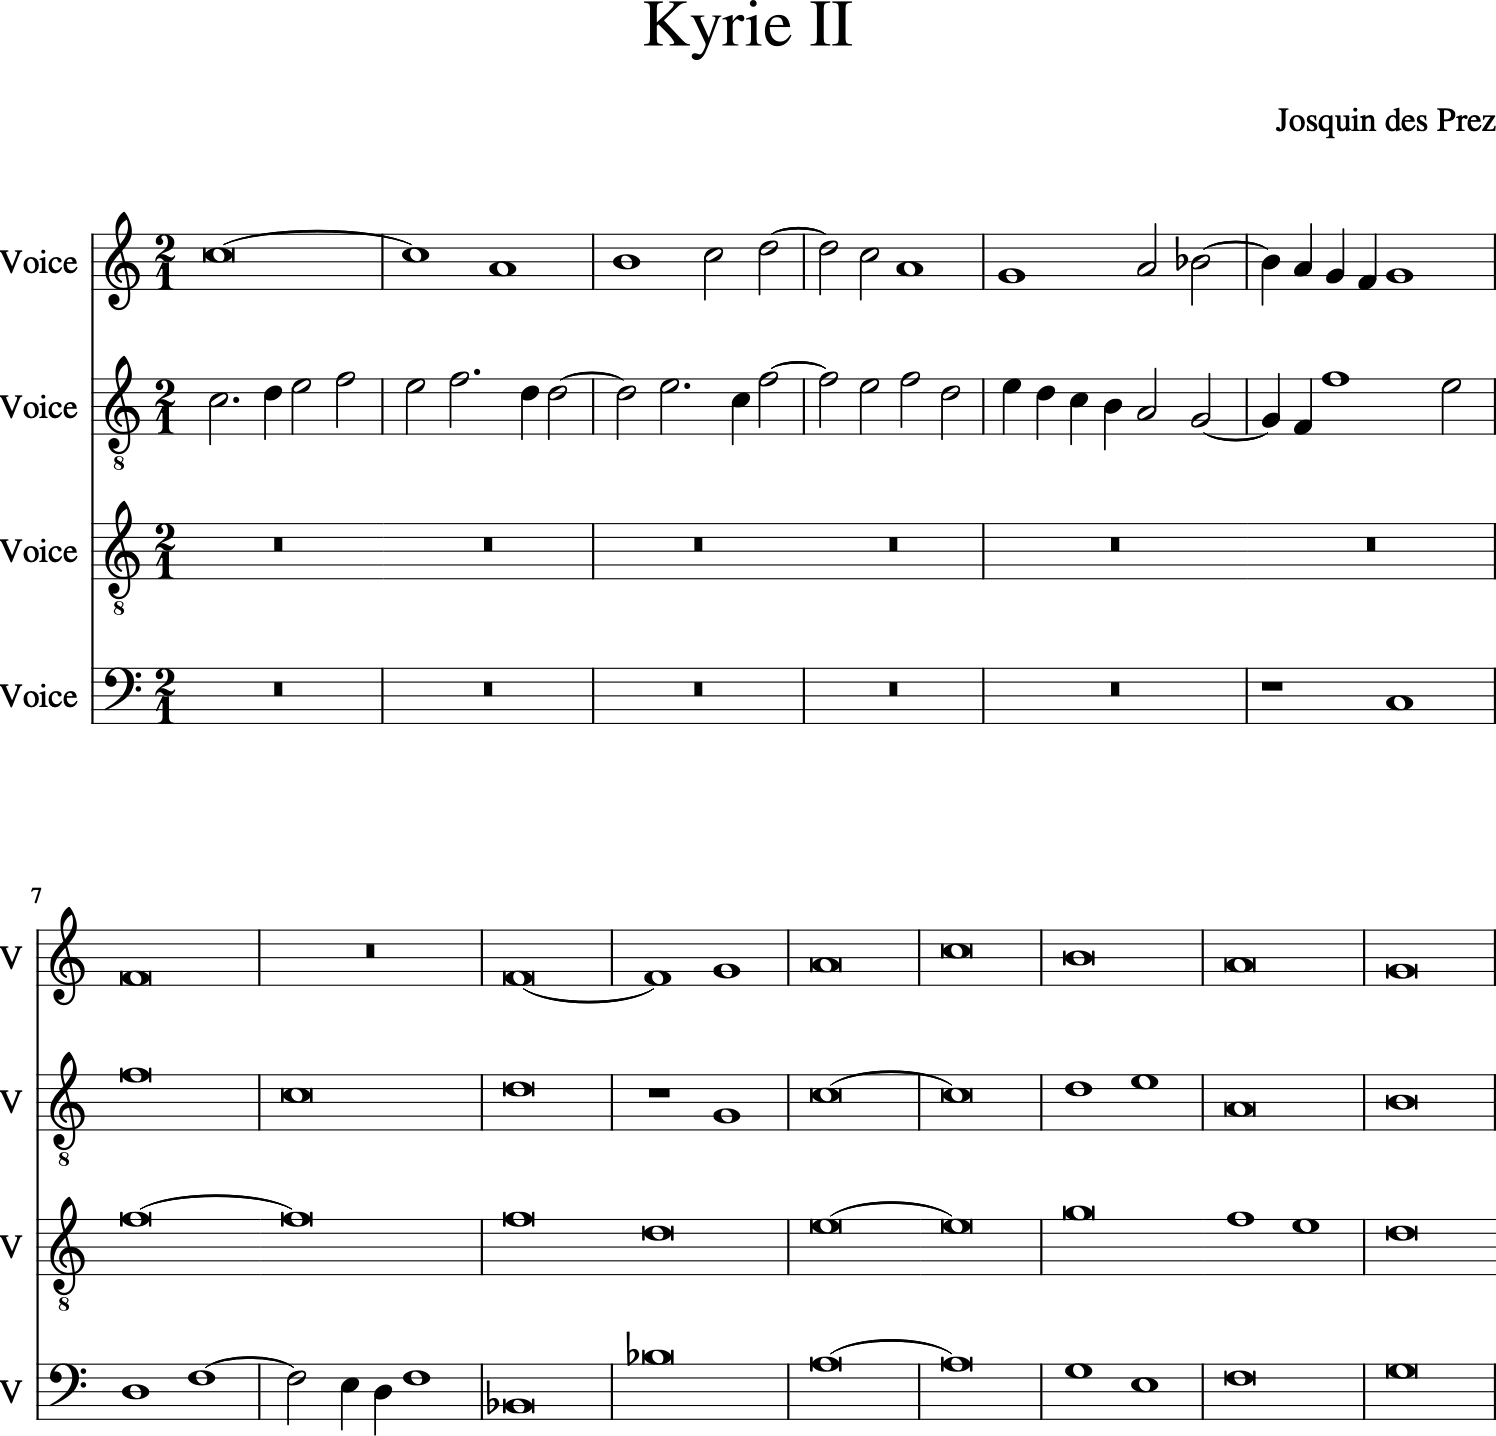

In [10]:
#score.show()
score = sc.measures(16, 30)
score.show()

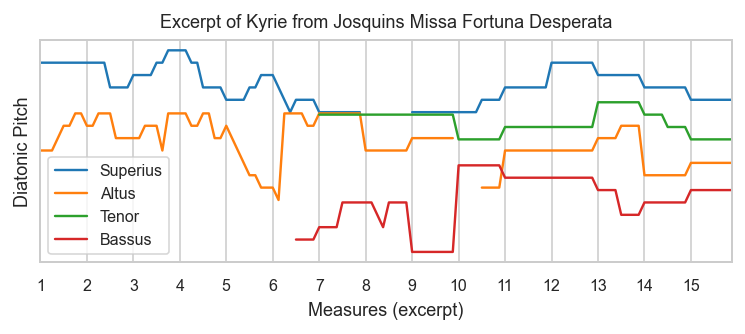

In [11]:
sns.set_context("paper")

# plot of polyphony excerpt 
df_pitchs = asc.Score_Pitch_Steps(score)
x_r = np.array([0,119])

fig= plt.figure(figsize=(6,2.2))
sns.set_style("whitegrid")
axes= fig.add_axes([0.1,0.2,0.8,0.7])
clabels = df_pitchs.columns
for i in range(len(clabels)):    
    axes.plot(df_pitchs[clabels[i]]+-.1*i)
step = np.min(np.diff(df_pitchs.index))
#plt.grid(color='k', linestyle=':', linewidth=1)
axes.legend(('Superius', 'Altus', 'Tenor','Bassus'),fontsize=8)
axes.set_yticks([])
axes.xaxis.set_ticks(np.arange(0,118,8))
axes.xaxis.set_ticklabels(np.arange(1,16),fontsize=8)
plt.xlabel('Measures (excerpt)',fontsize=9)
plt.ylabel('Diatonic Pitch',fontsize=9)
plt.title('Excerpt of Kyrie from Josquin''s Missa Fortuna Desperata',fontsize=9)

axes.set_xbound(lower=x_r[0], upper=x_r[1])
plt.savefig("pitch_1.png",dpi = 400)
plt.show()


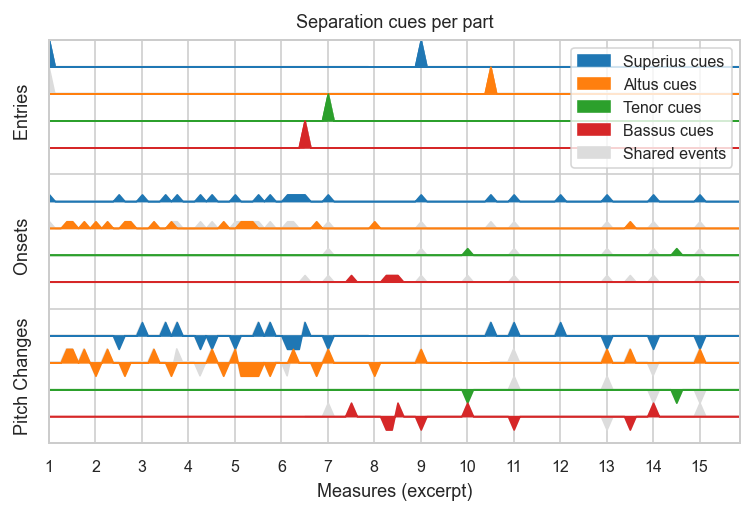

In [12]:
sns.set_context("paper")
# individual cues from this excerpt: ENTRY CUES
x_r = np.array([0,119])
fig= plt.figure(figsize=(6,3.5))
sns.set_style("whitegrid")
axes= fig.add_axes([0.1,0.15,0.8,0.8])
df_cues = asc.Entry_Cues(score)
df_seperated = asc.Cue_Reduction(df_cues)
offset = 14
for i in range(4):    
    axes.fill_between(df_seperated.index,df_seperated['Voice_'+str(i+1)]+offset-i,offset-i,color='C'+str(i))
for i in range(4): 
    axes.fill_between(df_cues.index,df_cues['Voice_'+str(i+1)]+offset-i,offset-i,color='gainsboro')
for i in range(4):    
    axes.fill_between(df_seperated.index,df_seperated['Voice_'+str(i+1)]+offset-i,offset-i,color='C'+str(i))

    
df_cues = 0.25*asc.Onset_Cues(score)
df_seperated = asc.Cue_Reduction(df_cues) 
offset = 9
for i in range(4): 
    axes.fill_between(df_cues.index,df_cues['Voice_'+str(i+1)]+offset-i,offset-i,color='gainsboro')
for i in range(4):    
    axes.fill_between(df_seperated.index,df_seperated['Voice_'+str(i+1)]+offset-i,offset-i,color='C'+str(i))

df_cues = 0.5*asc.Motion_Cues(score)
df_seperated = asc.Cue_Reduction(df_cues) 
offset = 4
for i in range(4): 
    axes.fill_between(df_cues.index,df_cues['Voice_'+str(i+1)]+offset-i,offset-i,color='gainsboro')
for i in range(4):    
    axes.fill_between(df_seperated.index,df_seperated['Voice_'+str(i+1)]+offset-i,offset-i,color='C'+str(i))
   
    
axes.set_xbound(lower=x_r[0], upper=x_r[1])
axes.set_ybound(lower=0, upper=15)
axes.yaxis.set_ticks([5,10,15])   
axes.yaxis.set_ticklabels(['Pitch Changes   ','Onsets          ','Entries          '],rotation=90,fontsize=9)
axes.xaxis.set_ticks(np.arange(0,118,8))
axes.xaxis.set_ticklabels(np.arange(1,16),fontsize=8)
plt.xlabel('Measures (excerpt)',fontsize=9)
#plt.ylabel('All Cues')
plt.title('Separation cues per part',fontsize=9)

#plt.grid(color='k', linestyle=':', linewidth=1)
axes.legend(('Superius cues', 'Altus cues', 'Tenor cues','Bassus cues','Shared events'),loc=1,fontsize=8)
plt.savefig("cues_Each_1.png",dpi = 400)
plt.show()

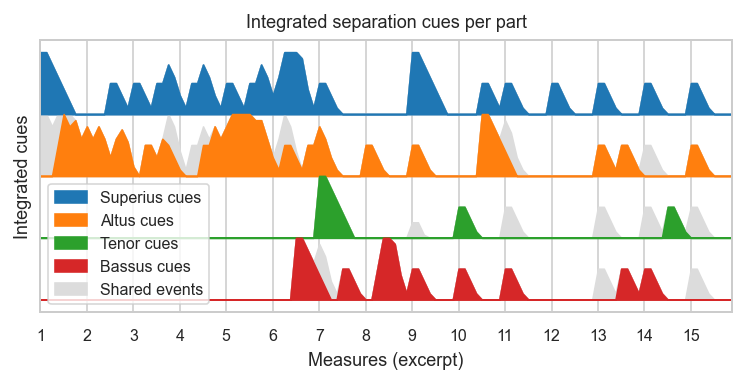

In [14]:
# all the cues together
sns.set_context("paper")
df_cues = asc.All_Cues(score)
df_seperated = asc.All_Cues_Reduced(score)

sns.set_style("whitegrid")
fig= plt.figure(figsize=(6,2.7))
axes= fig.add_axes([0.1,0.2,0.8,0.7])

axes.fill_between(df_seperated.index,df_seperated['Voice_1']+3,3,color='C0')
axes.fill_between(df_seperated.index,df_seperated['Voice_2']+2,2,color='C1')
axes.fill_between(df_seperated.index,df_seperated['Voice_3']+1,1,color='C2')
axes.fill_between(df_seperated.index,df_seperated['Voice_4'],0,color='C3')
axes.fill_between(df_cues.index,df_cues['Voice_1']+3,3,color='gainsboro')
axes.fill_between(df_cues.index,df_cues['Voice_2']+2,2,color='gainsboro')
axes.fill_between(df_cues.index,df_cues['Voice_3']+1,1,color='gainsboro')
axes.fill_between(df_cues.index,df_cues['Voice_4'],0,color='gainsboro')
axes.fill_between(df_seperated.index,df_seperated['Voice_1']+3,3,color='C0')
axes.fill_between(df_seperated.index,df_seperated['Voice_2']+2,2,color='C1')
axes.fill_between(df_seperated.index,df_seperated['Voice_3']+1,1,color='C2')
axes.fill_between(df_seperated.index,df_seperated['Voice_4'],0,color='C3')
axes.set_xbound(lower=x_r[0], upper=x_r[1])
axes.xaxis.set_ticks(np.arange(0,118,8))
axes.xaxis.set_ticklabels(np.arange(1,16),fontsize=8)
axes.set_yticks([])
plt.xlabel('Measures (excerpt)',fontsize=9)
plt.ylabel('Integrated cues',fontsize=9)
plt.title('Integrated separation cues per part',fontsize=9)
#plt.grid(color='k', linestyle=':', linewidth=1)
axes.legend(('Superius cues', 'Altus cues', 'Tenor cues','Bassus cues','Shared events'),loc=3,fontsize=8)
plt.savefig("cues_1.png",dpi = 400)
plt.show()

3.201652892561983


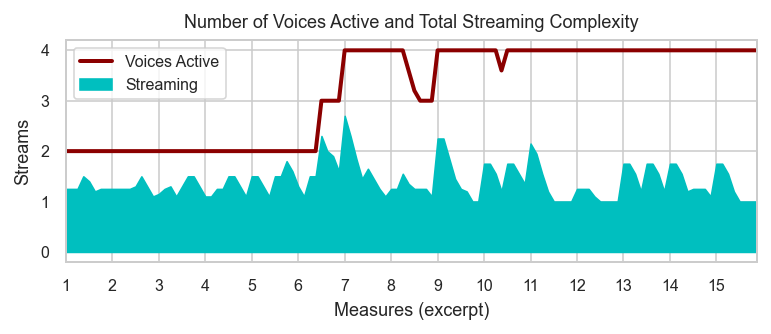

Voice_1    0.394248
Voice_2    0.454255
Voice_3    0.341667
Voice_4    0.442105
Total      1.404167
dtype: float64
120.0


In [15]:
sns.set_context("paper")
A =  asc.Voice_Count(score)
print(A.mean())
df_seperated = asc.Streaming_2(score)

x_r = np.array([0,119])
fig= plt.figure(figsize=(6,2.2))
axes= fig.add_axes([0.1,0.2,0.8,0.7])

sns.set_style("whitegrid")
axes.plot(A,color='darkred',linewidth=2)
axes.fill_between(df_seperated.index,df_seperated['Total'],0,color="c")
axes.set_xbound(lower=x_r[0], upper=x_r[1])
axes.xaxis.set_ticks(np.arange(0,118,8))
axes.xaxis.set_ticklabels(np.arange(1,16),fontsize=8)
plt.xlabel('Measures (excerpt)',fontsize=9)
locs, labels = plt.yticks(np.arange(0, 5, step=1),fontsize=8)
#plt.grid(color='k', linestyle=':', linewidth=1)
plt.ylabel('Streams',fontsize=9)
axes.legend(('Voices Active', 'Streaming'),fontsize=8)
plt.title('Number of Voices Active and Total Streaming Complexity',fontsize=9)

plt.savefig("Streams_1.png",dpi = 400)
plt.show()

print(df_seperated.mean())
print(A.index[-1])

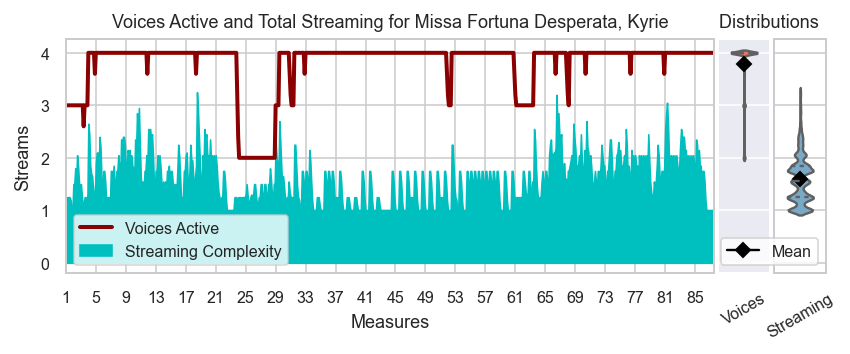

In [16]:
sns.set_context("paper")

# Mean values of voices counts per movement 

# os.chdir('/Users/finn/Documents/DDMAL/Scores/masses_all')
# f='Jos0802a-Missa_Fortuna_desperata-Kyrie.krn'
# #f='Jos0802b-Missa_Fortuna_desperata-Gloria.krn'
# score = m21.converter.parse(f)
# os.chdir('/Users/finn/Documents/DDMAL/dev/complexity/masses')

score = sc
A =  asc.Voice_Count(score)
df_seperated = asc.Streaming_2(score)
x_r = [df_seperated.index[0],df_seperated.index[-1]]

left, width = 0.08, 0.75
bottom, height = 0.2, 0.65
spacing = 0.005
miniWidth = 0.06

rect_series = [left, bottom, width, height]
rect_hist1 = [left + width + spacing, bottom, miniWidth, height]
rect_hist2 = [left + width + spacing + miniWidth + spacing, bottom, miniWidth, height]

# start with a square Figure
fig= plt.figure(figsize=(6,2.5))
sns.set_style("whitegrid")
ax = fig.add_axes(rect_series)
ax.plot(A,color='darkred',linewidth=2)
ax.fill_between(df_seperated.index,df_seperated['Total'],0,color="c")
ax.set_xbound(lower=x_r[0], upper=x_r[1])
ticks = np.arange(x_r[0],x_r[1],32)
ax.yaxis.set_ticks(np.arange(0, 6, step=1))
ax.yaxis.set_ticklabels(np.arange(0, 6, step=1),fontsize=8)
ax.xaxis.set_ticks(ticks)
ax.xaxis.set_ticklabels(np.arange(1,len(ticks)*4,4),fontsize=8)
plt.xlabel('Measures',fontsize=9)
ax.legend(('Voices Active', 'Streaming Complexity'),fontsize=8)
plt.ylabel('Streams',fontsize=9)

plt.title('Voices Active and Total Streaming for Missa Fortuna Desperata, Kyrie',fontsize=9)


df_A = pd.DataFrame(dict(x = [],g = []))
df = pd.DataFrame(dict(x=A, g='Voices Active'))
df_A = df_A.append(df, ignore_index=True)

sns.set_style("darkgrid")
ax_hist1 = fig.add_axes(rect_hist1, sharey=ax)
ax_hist1.plot(0,A.mean(),color ='black', marker="D", markersize=5)               
sns.violinplot(x='g', y='x',data=df_A, width=1,palette="Reds",bw=.05,inner='quartile')
ax_hist1.tick_params(axis="y", labelleft=False)
ax_hist1.set_xbound(lower=-1, upper=1)
plt.title('          Distributions',fontsize=9)
ax_hist1.set_xticklabels(['Voices'],fontsize=9)
ax_hist1.tick_params('x',labelsize=8,labelrotation = 30)
plt.xlabel('')
plt.ylabel('')


df_A = pd.DataFrame(dict(x = [],g = []))
df = pd.DataFrame(dict(x=df_seperated['Total'], g='Streaming Complexity'))
df_A = df_A.append(df, ignore_index=True)

sns.set_style("whitegrid")
ax_hist2 = fig.add_axes(rect_hist2, sharey=ax)

ax_hist2.plot(0,df_seperated['Total'].mean(),color ='black', marker="D", markersize=5)                  
sns.violinplot(x='g', y='x',data=df_A, width=1,palette="Blues",bw=.1,inner='quartile')
ax_hist2.tick_params(axis="y", labelleft=False)
ax_hist2.set_xbound(lower=-1, upper=1)
ax_hist2.legend((['Mean']),loc=4,fontsize=8)
ax_hist2.set_xticklabels(['Streaming'],fontsize=8)#, 
ax_hist2.tick_params('x',labelsize=8,labelrotation = 30)
plt.xlabel('')
plt.ylabel('')


plt.savefig("Streams_dist1.png",dpi = 400)
plt.show()


# Processing all masses streaming time series

From Masses_Comp_stats-5

In [17]:
os.chdir('/Users/finn/Documents/DDMAL/Scores')
f=open('Masses_CompSeries_Stream3_3.pkl','rb')
S_Complexities=pickle.load(f)
f.close()

MusicIndex = S_Complexities['MusicIndex']
Counterpoint_seperated = S_Complexities['Streaming_Complexity']
Voices_counted = S_Complexities['Voice_Counts']

os.chdir('/Users/finn/Documents/DDMAL/dev/complexity/masses')

Mass                            Missa_Malheur_me_bat
MassID                                       Agr1004
Mvnt                                          Gloria
MvntN                                              1
Composer                          Alexander Agricola
CompID                                           Agr
file        Agr1004b-Missa_Malheur_me_bat-Gloria.krn
Name: 5, dtype: object


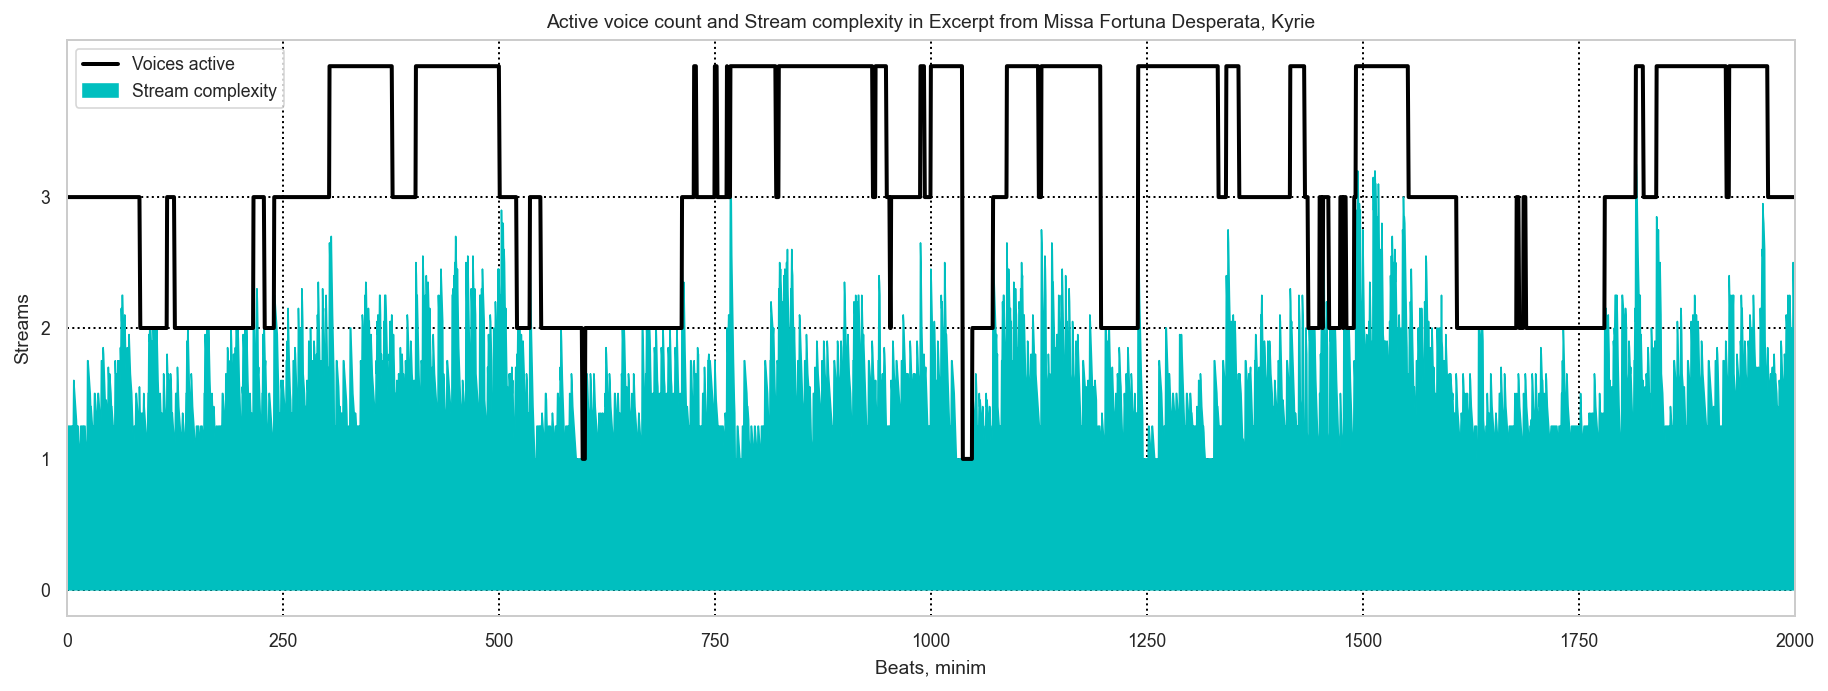

1.6070980483271375
3.45
3.142288037166086
2152.0


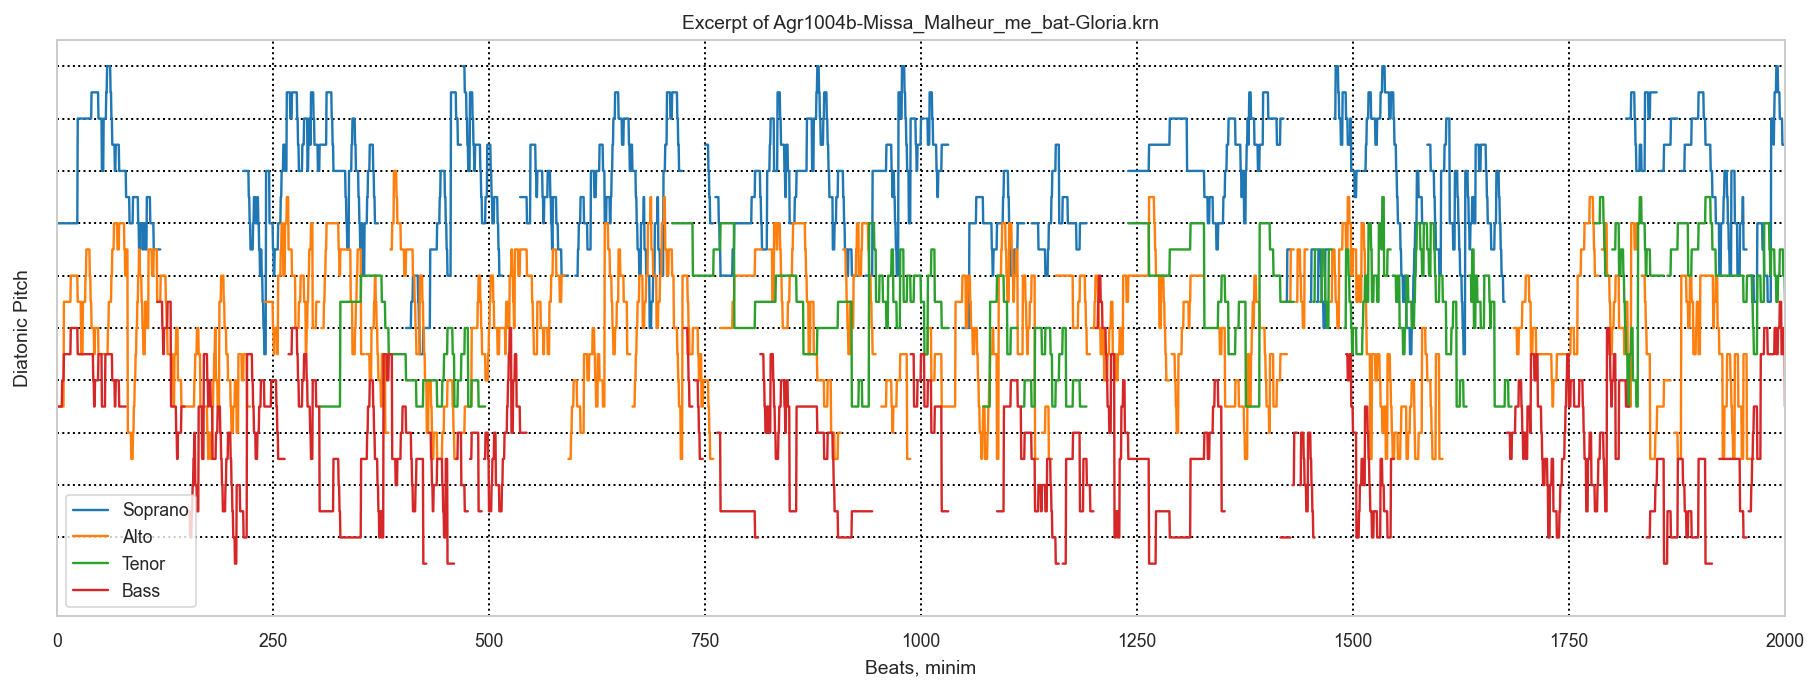

In [18]:
# test the outputs of corpus evaluation
piece = 5

df_seperated = Counterpoint_seperated[5]
A = Voices_counted[5]
dets = MusicIndex.loc[5,:]
print(dets)

os.chdir('/Users/finn/Documents/DDMAL/Scores/masses_all')
score = m21.converter.parse(dets.file)
df_pitchs = asc.Score_Pitch_Steps(score)

x_r = np.array([0,2000])
os.chdir('/Users/finn/Documents/DDMAL/dev/complexity/masses')



fig= plt.figure(figsize=(15,5))
axes= fig.add_axes([0.1,0.1,0.8,0.8])
axes.plot(A,color="k",linewidth=2)
axes.fill_between(df_seperated.index,df_seperated,0,color="c")
axes.set_xbound(lower=x_r[0], upper=x_r[1])
locs, labels = plt.yticks(np.arange(0, 4, step=1))
plt.grid(color='k', linestyle=':', linewidth=1)
plt.xlabel('Beats, minim')
plt.ylabel('Streams')
axes.legend(('Voices active', 'Stream complexity'))
plt.title('Active voice count and Stream complexity in Excerpt from Missa Fortuna Desperata, Kyrie')
plt.show()

print(df_seperated.mean())
print(df_seperated.max())
print(A.mean())
print(A.index[-1])

fig= plt.figure(figsize=(15,5))
axes= fig.add_axes([0.1,0.1,0.8,0.8])
axes.plot(df_pitchs)
step = np.min(np.diff(df_pitchs.index))
plt.grid(color='k', linestyle=':', linewidth=1)
axes.legend(('Soprano', 'Alto', 'Tenor','Bass'))
axes.yaxis.set_ticklabels([])
plt.xlabel('Beats, minim')
plt.ylabel('Diatonic Pitch')
plt.title('Excerpt of ' + dets.file)

axes.set_xbound(lower=x_r[0], upper=x_r[1])
locs, labels = plt.yticks(np.arange(25, 44, step=2))
plt.show()

# Trends on central tendencies

In [30]:
# save these results from the last above cell
os.chdir('/Users/finn/Documents/DDMAL/Scores')
f=open('Masses_Comp_Summary_Stats_Stream_3.pkl','rb')
Summary_Streaming=pickle.load(f)
f.close()

df_cycles = Summary_Streaming['Cycle_stats']
cyc_df = Summary_Streaming['Movement_stats'] 
mainCycle = ['Kyrie','Gloria', 'Credo', 'Sanctus', 'Agnus']
os.chdir('/Users/finn/Documents/DDMAL/dev/complexity/masses')

In [31]:
len(cyc_df)

1042

In [32]:
df_cycles['Composer'].value_counts()

Giovanni Pierluigi da Palestrina    101
Pierre de la Rue                     26
Unverified Josquin                   18
Tomás Luis de Victoria               17
Josquin des Prez                     12
Johannes Ockeghem                    11
Johannes Martini                      8
Marbrianus de Orto                    5
Guillaume Du Fay                      4
Anonymus                              3
Obrecht                               3
Alexander Agricola                    2
Johannes Tinctoris                    2
Pipelare                              1
Ludwig Daser                          1
Antoine de Fevin                      1
Antoine Busnoys                       1
Name: Composer, dtype: int64

In [33]:
print(sp.stats.spearmanr(cyc_df.C_Mean,cyc_df.V_Max))
print(sp.stats.spearmanr(cyc_df.C_Mean,cyc_df.V_Mean))
print(len(cyc_df.C_Mean)-2)
cyc_df.corr(method='spearman') 
# rho(V_max,C_max)= 0.82 Very high. with C_Mean is lower 0.72. There is variance beyond the number of voices
# also zoom in to relative values within cycles and C_R_mean,V_R_mean down to 0.49

SpearmanrResult(correlation=0.7334445862409085, pvalue=1.4800590804610654e-176)
SpearmanrResult(correlation=0.8117775919090897, pvalue=3.36740546647758e-245)
1040


,C_Mean,C_Max,V_Mean,V_Max,C_R_Mean,C_R_Max,V_R_Mean,V_R_Max,Time
C_Mean,1.000000,0.803161,0.811778,0.733445,0.389263,0.117647,0.203982,-0.118730,0.715586
C_Max,0.803161,1.000000,0.719756,0.752361,0.242174,0.364116,0.086274,-0.006005,0.533070
V_Mean,0.811778,0.719756,1.000000,0.877648,0.223554,0.002697,0.339943,0.043467,0.631660
V_Max,0.733445,0.752361,0.877648,1.000000,0.128823,-0.001177,0.141631,0.176942,0.550634
C_R_Mean,0.389263,0.242174,0.223554,0.128823,1.000000,0.420307,0.556755,0.243752,-0.012131
C_R_Max,0.117647,0.364116,0.002697,-0.001177,0.420307,1.000000,0.170538,0.192037,-0.072455
V_R_Mean,0.203982,0.086274,0.339943,0.141631,0.556755,0.170538,1.000000,0.333437,-0.049090
V_R_Max,-0.118730,-0.006005,0.043467,0.176942,0.243752,0.192037,0.333437,1.000000,-0.357031
Time,0.715586,0.533070,0.631660,0.550634,-0.012131,-0.072455,-0.049090,-0.357031,1.000000


In [34]:
print(cyc_df['V_Max'].value_counts())
#cyc_df = cyc_df[cyc_df.V_Max>2]
A_df = cyc_df[cyc_df.V_Max==5]
print(sp.stats.spearmanr(A_df.C_Mean,A_df.V_Mean))
print([A_df.V_Max.loc[71],len(A_df.C_Mean)-2])
A_df = cyc_df[cyc_df.V_Max==4]
print(sp.stats.spearmanr(A_df.C_Mean,A_df.V_Mean))
print([A_df.V_Max.loc[1],len(A_df.C_Mean)-2])
A_df.corr(method='spearman') 

4.0     546
5.0     274
6.0     151
8.0      36
3.0      15
7.0      10
9.0       5
12.0      5
Name: V_Max, dtype: int64
SpearmanrResult(correlation=0.4322290847838293, pvalue=6.716481165898657e-14)
[5.0, 272]
SpearmanrResult(correlation=0.5706299162849707, pvalue=1.730973488791463e-48)
[4.0, 544]


,C_Mean,C_Max,V_Mean,V_Max,C_R_Mean,C_R_Max,V_R_Mean,V_R_Max,Time
C_Mean,1.000000,0.589942,0.570630,NaN,0.388162,0.130743,0.073704,-0.534504,0.582245
C_Max,0.589942,1.000000,0.189392,NaN,0.283413,0.589263,-0.016022,-0.240926,0.192048
V_Mean,0.570630,0.189392,1.000000,NaN,0.277388,0.012949,0.538207,-0.269627,0.380186
V_Max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C_R_Mean,0.388162,0.283413,0.277388,NaN,1.000000,0.418393,0.505829,0.208710,-0.149834
C_R_Max,0.130743,0.589263,0.012949,NaN,0.418393,1.000000,0.128292,0.246791,-0.128709
V_R_Mean,0.073704,-0.016022,0.538207,NaN,0.505829,0.128292,1.000000,0.317716,-0.240944
V_R_Max,-0.534504,-0.240926,-0.269627,NaN,0.208710,0.246791,0.317716,1.000000,-0.698575
Time,0.582245,0.192048,0.380186,NaN,-0.149834,-0.128709,-0.240944,-0.698575,1.000000


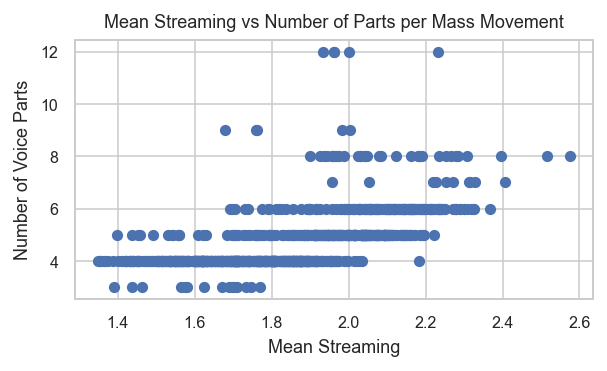

In [35]:
sns.set_context("paper")
fig= plt.figure(figsize=(6,3))
bplot=sns.set_style("whitegrid")
axes= fig.add_axes([0.2,0.22,0.6,0.6])
plt.scatter(cyc_df.C_Mean,cyc_df.V_Max)
plt.xlabel('Mean Streaming',fontsize=9)
plt.ylabel('Number of Voice Parts',fontsize=9)
plt.tick_params('x',labelsize=8)
plt.tick_params('y',labelsize=8)

plt.title('Mean Streaming vs Number of Parts per Mass Movement',fontsize=9)
# rho = 0.78
plt.savefig("Voices_vs_Streaming_scatter.png",dpi = 400)
plt.show()

1576-1600    477
1501-1525    244
1476-1500    129
1551-1575    107
1450-1475     85
Name: Era, dtype: int64
LinregressResult(slope=0.22832230439289553, intercept=3.1591302564443913, rvalue=0.5843552209563879, pvalue=2.739033176034132e-24, stderr=0.020134136771756076)
LinregressResult(slope=0.0832560822820493, intercept=1.5967842034011037, rvalue=0.6970741407948581, pvalue=1.0660726387620385e-37, stderr=0.005437881512632108)
1501-1525    184
1576-1600    130
1476-1500    105
1450-1475     77
1551-1575     50
Name: Era, dtype: int64
LinregressResult(slope=0.06257016884401827, intercept=3.215508865012003, rvalue=0.42489474715496967, pvalue=3.588419230073226e-10, stderr=0.009473673858808967)
LinregressResult(slope=0.048481773184264346, intercept=1.5990053397072845, rvalue=0.6033716910579648, pvalue=3.214649732915753e-21, stderr=0.004553757820280876)


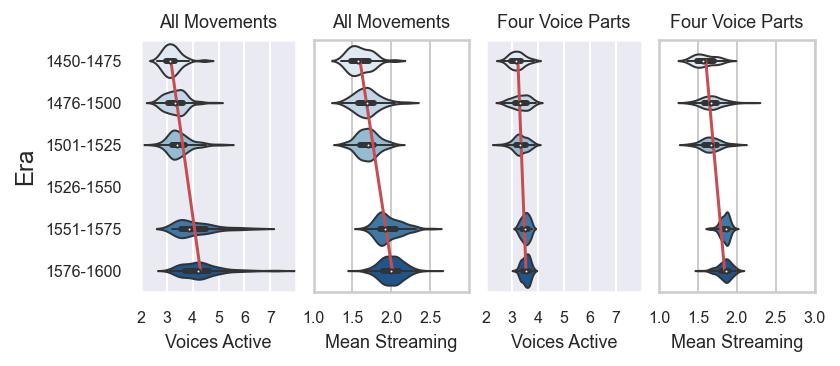

In [36]:
#boxplot on distributions by ERA

# SingleFactor on average values of summary stats on selected streaming complexity measure
# https://cmdlinetips.com/2018/02/how-to-subset-pandas-dataframe-based-on-values-of-a-column/
# https://cmdlinetips.com/2018/03/how-to-make-boxplots-in-python-with-pandas-and-seaborn/
# gather a random subset of movements per era overwhich to regress 
sampN = 50;
print(cyc_df['Era'].value_counts())
A = []
for i in range(7):
    if len(cyc_df.loc[cyc_df['Time'] == i])>sampN-1:
        A.append(cyc_df.loc[cyc_df['Time'] == i].sample(n=sampN))
times_df = pd.concat(A)
years = ['1450-1475', '1476-1500','1501-1525', '1526-1550', '1551-1575', '1576-1600']



left, width = 0.17, 0.18
bottom, height = 0.2, 0.7
spacing = 0.02
n = 1
rect = [left + (n-1)*(width + spacing), bottom, width, height]

# start with a square Figure
fig= plt.figure(figsize=(6,2.5))
sns.set_context("paper")

#axes.set_title("Mean Streaming complexity and voice count per movement",fontsize=14)
sns.set(style="darkgrid")
ax = fig.add_axes(rect)
st = 'V_Mean'
sns.violinplot(y='Era', x=st,data=cyc_df,order=years,width=0.8,palette="Blues",linewidth=1)
print(sp.stats.linregress(times_df['Time'],times_df[st]))
slope, intercept, r_value, p_value, std_err = sp.stats.linregress(times_df['Time'],times_df[st])
plt.plot(intercept + slope*times_df['Time'], times_df['Time'],'r', label='fitted line')
ax.axes.set_xbound(lower=2,upper=8)
ax.axes.set_ybound(lower=-0.5,upper=5.5)
ax.set_xticks(np.arange(2,8))
ax.set_xlabel("Voices Active",fontsize=9)
ax.tick_params(labelsize=8)
ax.set_yticklabels(years)
ax.set_title('All Movements',fontsize=9)


n += 1
rect = [left + (n-1)*(width + spacing), bottom, width, height]
sns.set_style("whitegrid")
bplot= fig.add_axes(rect, sharey=ax)
st = 'C_Mean'
sns.violinplot(y='Era', x=st,data=cyc_df,order=years,width=0.8,palette="Blues",linewidth=1)
print(sp.stats.linregress(times_df['Time'],times_df[st]))
slope, intercept, r_value, p_value, std_err = sp.stats.linregress(times_df['Time'],times_df[st])
plt.plot(intercept + slope*times_df['Time'], times_df['Time'],'r', label='fitted line')
bplot.axes.set_xbound(lower=1,upper=3)
bplot.axes.set_ybound(lower=-0.5,upper=5.5)
bplot.set_xticks(np.arange(1,3.0,0.5))
bplot.set_xlabel("Mean Streaming",fontsize=9)
bplot.tick_params('x',labelsize=8)
bplot.tick_params(axis="y", labelleft=False)
bplot.set_ylabel('')
bplot.set_title('All Movements',fontsize=9)


A_df = cyc_df[cyc_df.V_Max==4]
print(A_df['Era'].value_counts())
A = []
for i in range(7):
    if len(A_df.loc[A_df['Time'] == i])>sampN:
        A.append(A_df.loc[A_df['Time'] == i].sample(n=sampN))
times_df = pd.concat(A)

n += 1
rect = [left + (n-1)*(width + spacing), bottom, width, height]
sns.set(style="darkgrid")
bplot= fig.add_axes(rect, sharey=ax)
st = 'V_Mean'
sns.violinplot(y='Era', x=st,data=A_df,order=years,width=0.8,palette="Blues",linewidth=1)
print(sp.stats.linregress(times_df['Time'],times_df[st]))
slope, intercept, r_value, p_value, std_err = sp.stats.linregress(times_df['Time'],times_df[st])
plt.plot(intercept + slope*times_df['Time'], times_df['Time'],'r', label='fitted line')
bplot.axes.set_xbound(lower=2,upper=8)
bplot.axes.set_ybound(lower=-0.5,upper=5.5)
bplot.set_xticks(np.arange(2,8))
bplot.set_xlabel("Voices Active",fontsize=9)
bplot.tick_params('x',labelsize=8)
bplot.tick_params(axis="y", labelleft=False)
bplot.set_ylabel('')
bplot.set_title('Four Voice Parts',fontsize=9)

n += 1
rect = [left + (n-1)*(width + spacing), bottom, width, height]
sns.set_style("whitegrid")
bplot= fig.add_axes(rect, sharey=ax)
st = 'C_Mean'
sns.violinplot(y='Era', x=st,data=A_df,order=years,width=0.8,palette="Blues",linewidth=1)
print(sp.stats.linregress(times_df['Time'],times_df[st]))
slope, intercept, r_value, p_value, std_err = sp.stats.linregress(times_df['Time'],times_df[st])
plt.plot(intercept + slope*times_df['Time'], times_df['Time'],'r', label='fitted line')

bplot.axes.set_xbound(lower=1,upper=3)
bplot.axes.set_ybound(lower=-0.5,upper=5.5)
bplot.set_xticks(np.arange(1,3.5,0.5))
bplot.set_xlabel("Mean Streaming",fontsize=9)
bplot.tick_params('x',labelsize=8)
bplot.tick_params(axis="y", labelleft=False)
bplot.set_ylabel('')
bplot.set_title('Four Voice Parts',fontsize=9)

plt.savefig("Era_trends.png",dpi = 300)

In [37]:

# median performance of regression 
st = 'V_Mean'
k = []
kp = []
f = []
fp = []
for i in range (100):
    A = []
    B = []
    for i in range(6):
        if len(cyc_df.loc[cyc_df['Time'] == i])>sampN:
            A.append(cyc_df.loc[cyc_df['Time'] == i].sample(n=sampN))
            B.append(A[-1][st])
    times_df = pd.concat(A)
    a = sp.stats.linregress(times_df['Time'],times_df[st])
    k.append(a.rvalue**2)
    kp.append(a.pvalue)
    b = sp.stats.f_oneway(B[0],B[1],B[2],B[3],B[4]) # https://www.pythonfordatascience.org/anova-python/
    f.append(b.statistic)
    fp.append(b.pvalue)
print(st)
print(np.median(k))
print(np.median(kp))
print(np.median(f))
print(np.median(fp))

st = 'C_Mean'
k = []
kp = []
f = []
fp = []
for i in range (100):
    A = []
    B = []
    for i in range(6):
        if len(cyc_df.loc[cyc_df['Time'] == i])>sampN:
            A.append(cyc_df.loc[cyc_df['Time'] == i].sample(n=sampN))
            B.append(A[-1][st])
    times_df = pd.concat(A)
    a = sp.stats.linregress(times_df['Time'],times_df[st])
    k.append(a.rvalue**2)
    kp.append(a.pvalue)
    b = sp.stats.f_oneway(B[0],B[1],B[2],B[3],B[4]) # https://www.pythonfordatascience.org/anova-python/
    f.append(b.statistic)
    fp.append(b.pvalue)
print(st)
print(np.median(k))
print(np.median(kp))
print(np.median(f))
print(np.median(fp))

sampN = 45

A_df = cyc_df[cyc_df.V_Max==4]
st = 'V_Mean'
k = []
kp = []
f = []
fp = []
for i in range (100):
    A = []
    B = []
    for i in range(6):
        if len(A_df.loc[A_df['Time'] == i])>sampN:
            A.append(A_df.loc[A_df['Time'] == i].sample(n=sampN))
            B.append(A[-1][st])
    times_df = pd.concat(A)
    a = sp.stats.linregress(times_df['Time'],times_df[st])
    k.append(a.rvalue**2)
    kp.append(a.pvalue)
    b = sp.stats.f_oneway(B[0],B[1],B[2],B[3],B[4]) # https://www.pythonfordatascience.org/anova-python/
    f.append(b.statistic)
    fp.append(b.pvalue)
print(st)
print(np.median(k))
print(np.median(kp))
print(np.median(f))
print(np.median(fp))

st = 'C_Mean'
k = []
kp = []
f = []
fp = []
for i in range (100):
    A = []
    B = []
    for i in range(6):
        if len(A_df.loc[A_df['Time'] == i])>sampN:
            A.append(A_df.loc[A_df['Time'] == i].sample(n=sampN))
            B.append(A[-1][st])
    times_df = pd.concat(A)
    a = sp.stats.linregress(times_df['Time'],times_df[st])
    k.append(a.rvalue**2)
    kp.append(a.pvalue)
    b = sp.stats.f_oneway(B[0],B[1],B[2],B[3],B[4]) # https://www.pythonfordatascience.org/anova-python/
    f.append(b.statistic)
    fp.append(b.pvalue)
print(st)
print(np.median(k))
print(np.median(kp))
print(np.median(f))
print(np.median(fp))


V_Mean
0.3623294041363231
4.929207925581437e-26
36.49697639495383
6.384672810551638e-24
C_Mean
0.5093691332951463
3.182621159019309e-40
71.26278255439009
5.889113912884743e-40
V_Mean
0.1948644928993273
3.7955108498297615e-12
14.919814260748078
8.366464564987875e-11
C_Mean
0.4206240200365115
3.0398543917618713e-28
45.90089244407072
5.9382067970287335e-28


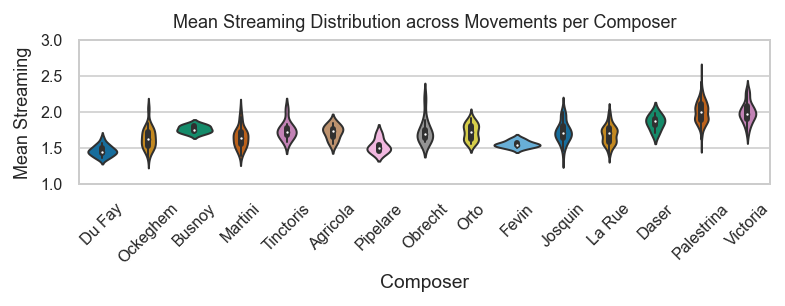

In [38]:
sns.set_context("paper")
#boxplot on distributions by composer, ordered roughly chronologically
years = cyc_df.Era.unique()

sns.set_style("whitegrid")
fig= plt.figure(figsize=(6,2))
bplot= fig.add_axes([0.1,0.4,0.8,0.5])
composers_ordered=['Guillaume Du Fay','Johannes Ockeghem','Antoine Busnoys',
                   'Johannes Martini','Johannes Tinctoris','Alexander Agricola',
                   'Pipelare','Obrecht','Marbrianus de Orto','Antoine de Fevin',
                   'Josquin des Prez','Pierre de la Rue','Ludwig Daser',
                  'Giovanni Pierluigi da Palestrina','Tomás Luis de Victoria']
st = 'C_Mean'
sns.violinplot(x='Composer', y=st,data=cyc_df,order=composers_ordered
                       ,width=1,palette="colorblind",linewidth=1)

bplot.axes.set_ybound(lower=1,upper=3.0)

#bplot.set_xlabel("Era",fontsize=14)
bplot.set_ylabel("Mean Streaming",fontsize=9)
bplot.set_xticklabels(['Du Fay', 'Ockeghem','Busnoy', 
       'Martini','Tinctoris','Agricola','Pipelare', 'Obrecht','Orto',
       'Fevin','Josquin','La Rue','Daser','Palestrina','Victoria'])
bplot.tick_params('x',labelsize=8,labelrotation = 45)
bplot.tick_params('y',labelsize=8)
bplot.axes.set_title("Mean Streaming Distribution across Movements per Composer",fontsize=9)

plt.savefig("Composer_trends_SC.png",dpi = 300)

# Movement factors

        Source        SS  DF1  DF2            MS          F         p-unc  \
0     Composer  0.000004   16  197  2.209632e-07   0.010559  1.000000e+00   
1         Mvnt  2.190508    4  788  5.476271e-01  70.416465  5.342108e-51   
2  Interaction  1.372988   64  788  2.145293e-02   2.758519  6.426795e-11   

      p-GG-corr       np2       eps sphericity   W-spher       p-spher  
0           NaN  0.000857       NaN        NaN       NaN           NaN  
1  1.543344e-39  0.263321  0.847817      False  0.676793  1.502529e-12  
2           NaN  0.183035       NaN        NaN       NaN           NaN  



        Source         SS  DF1  DF2            MS           F         p-unc  \
0     Composer   0.000001   16  197  6.399936e-08    0.010559  1.000000e+00   
1         Mvnt  32.093491    4  788  8.023373e+00  148.832361  8.679936e-95   
2  Interaction  22.628853   64  788  3.535758e-01    6.558778  7.066713e-41   

      p-GG-corr       np2       eps sphericity   W-spher       p-spher  
0     

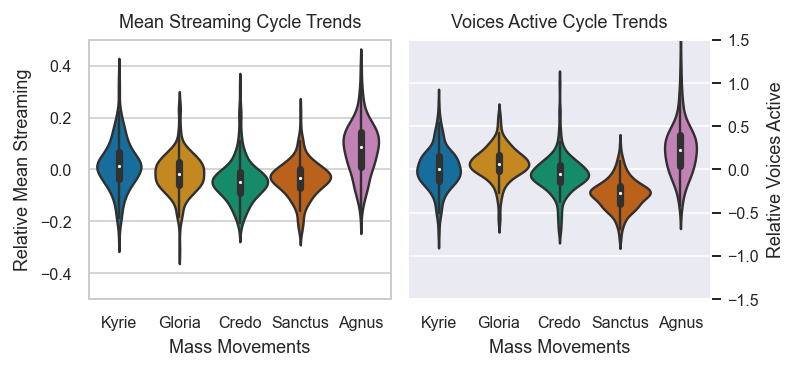

In [46]:
# relative voice count and complexity of mass movements

left, width = 0.14, 0.35
bottom, height = 0.18, 0.72
spacing = 0.02

# start with a square Figure
fig= plt.figure(figsize=(6,2.5))
sns.set_context("paper")
sns.set_style("whitegrid")
n = 1
rect = [left + (n-1)*(width + spacing), bottom, width, height]
ax1 = fig.add_axes(rect)


st = 'C_R_Mean'   
aov = pg.mixed_anova(data=cyc_df, dv=st, within='Mvnt', subject='MassID', between = 'Composer', correction = True)
print(aov)
print('\n\n')
sns.violinplot(x='Mvnt', y=st,data=cyc_df, 
                 width=1,palette="colorblind", order = mainCycle)
ax1.axes.set_xlabel("Relative Mean Streaming",fontsize=9)
ax1.axes.set_ybound(lower=-0.5,upper=0.5)
ax1.set_ylabel("Relative Mean Streaming",fontsize=9)
ax1.set_title("Mean Streaming Cycle Trends",fontsize=9)
ax1.set_xlabel("Mass Movements",fontsize=9)
ax1.tick_params(labelsize=8)

sns.set_style("darkgrid")
n += 1
rect = [left + (n-1)*(width + spacing), bottom, width, height]
ax2 = fig.add_axes(rect)


st = 'V_R_Mean'
aov = pg.mixed_anova(data=cyc_df, dv=st, within='Mvnt', subject='MassID', between = 'Composer', correction = True)
print(aov)
sns.violinplot(x='Mvnt', y=st,data=cyc_df, 
                 width=1,palette="colorblind", order = mainCycle)
ax2.axes.set_ybound(lower=-1.5,upper=1.5)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.set_xlabel("Mass Movements",fontsize=9)
ax2.set_ylabel("Relative Voices Active",fontsize=9)
ax2.set_title("Voices Active Cycle Trends",fontsize=9)
ax2.tick_params(labelsize=8)

plt.savefig("Movements_Relative_Counts.png",dpi = 400)

77
        A        B   mean(A)   mean(B)      diff        se         T  \
0   Agnus    Credo  0.061921 -0.035745  0.097666  0.037973  2.571964   
1   Agnus   Gloria  0.061921 -0.013597  0.075518  0.035380  2.134477   
2   Agnus    Kyrie  0.061921  0.004989  0.056932  0.038382  1.483296   
3   Agnus  Sanctus  0.061921 -0.021502  0.083423  0.039131  2.131910   
4   Credo   Gloria -0.035745 -0.013597 -0.022148  0.022899 -0.967179   
5   Credo    Kyrie -0.035745  0.004989 -0.040734  0.027309 -1.491592   
6   Credo  Sanctus -0.035745 -0.021502 -0.014243  0.028352 -0.502356   
7  Gloria    Kyrie -0.013597  0.004989 -0.018586  0.023571 -0.788540   
8  Gloria  Sanctus -0.013597 -0.021502  0.007905  0.024771  0.319117   
9   Kyrie  Sanctus  0.004989 -0.021502  0.026491  0.028897  0.916754   

          df      pval    hedges  
0  23.748725  0.086991  0.900244  
1  19.444720  0.219104  0.760027  
2  24.523358  0.561562  0.511203  
3  25.560543  0.217059  0.734742  
4  24.407257  0.848118 -0.349

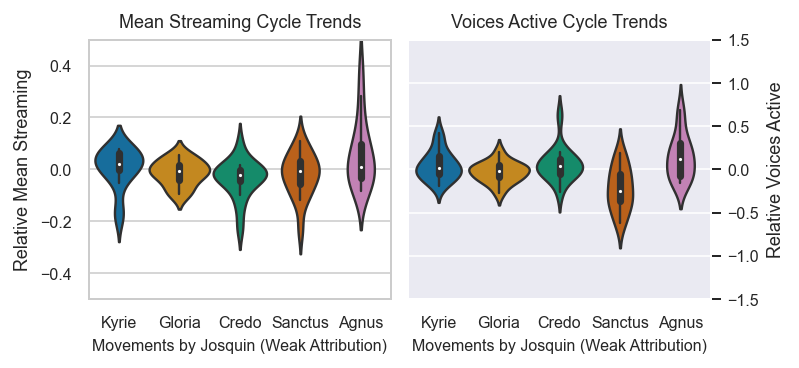

In [47]:
# relative voice count and complexity of mass movements
sns.set_context("paper")
st = 'C_R_Mean'
Wanted_Comp = 'Unverified Josquin' #'Giovanni Pierluigi da Palestrina'#,'Tomás Luis de Victoria','Pierre de la Rue','Josquin des Prez','Unverified Josquin','Johannes Ockeghem']
shortName='Josquin (Weak Attribution)'
# Wanted_Comp = 'Giovanni Pierluigi da Palestrina'
# shortName = 'Palestrina'
# Wanted_Comp = 'Josquin des Prez' #'Giovanni Pierluigi da Palestrina'#,'Tomás Luis de Victoria','Pierre de la Rue','Josquin des Prez','Unverified Josquin','Johannes Ockeghem']
# shortName='Josquin (Strong Attribution)'

Names = Wanted_Comp.split(' ')
Sub_df = cyc_df[cyc_df.Composer==Wanted_Comp]
print(len(Sub_df))

left, width = 0.14, 0.35
bottom, height = 0.18, 0.72
spacing = 0.02

# start with a square Figure
fig= plt.figure(figsize=(6,2.5))
sns.set_context("paper")
sns.set_style("whitegrid")
n = 1
rect = [left + (n-1)*(width + spacing), bottom, width, height]
ax1 = fig.add_axes(rect)

st = 'C_R_Mean'   
#https://pingouin-stats.org/generated/pingouin.pairwise_gameshowell.html#pingouin.pairwise_gameshowell
a = pg.pairwise_gameshowell(data=Sub_df, dv=st,between='Mvnt') 
print(a)
sns.violinplot(x='Mvnt', y=st,data=Sub_df, 
                 width=1,palette="colorblind", order = mainCycle)
ax1.axes.set_xlabel("Relative Mean Streaming",fontsize=9)
ax1.axes.set_ybound(lower=-0.5,upper=0.5)
ax1.set_ylabel("Relative Mean Streaming",fontsize=9)
ax1.set_title("Mean Streaming Cycle Trends",fontsize=9)
ax1.set_xlabel("Movements by " + shortName,fontsize=8)
ax1.tick_params(labelsize=8)

sns.set_style("darkgrid")
n += 1
rect = [left + (n-1)*(width + spacing), bottom, width, height]
ax2 = fig.add_axes(rect)

st = 'V_R_Mean'
#https://pingouin-stats.org/generated/pingouin.pairwise_gameshowell.html#pingouin.pairwise_gameshowell
a = pg.pairwise_gameshowell(data=Sub_df, dv=st,between='Mvnt') 
print(a)
sns.violinplot(x='Mvnt', y=st,data=Sub_df, 
                 width=1,palette="colorblind", order = mainCycle)
ax2.axes.set_ybound(lower=-1.5,upper=1.5)
ax2.tick_params(labelsize=8)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.set_xlabel("Movements by " + shortName,fontsize=8)
ax2.set_ylabel("Relative Voices Active",fontsize=9)
ax2.set_title("Voices Active Cycle Trends",fontsize=9)
ax2.tick_params(labelsize=8)

plt.savefig(shortName +"Movements_Relative_Counts.png",dpi = 400)



In [48]:

#https://pingouin-stats.org/generated/pingouin.pairwise_gameshowell.html#pingouin.pairwise_gameshowell
st = 'V_R_Mean'
pg.pairwise_gameshowell(data=cyc_df, dv=st,between='Mvnt')  
# https://pingouin-stats.org/generated/pingouin.pairwise_tukey.html#pingouin.pairwise_tukey
#pg.pairwise_tukey(data=cyc_df, dv=st,between='Mvnt') 

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,Agnus,Credo,0.254418,-0.056080,0.310498,0.030282,10.253438,330.921911,0.001000,1.007474
1,Agnus,Gloria,0.254418,0.071349,0.183069,0.029363,6.234680,305.780405,0.001000,0.608824
2,Agnus,Kyrie,0.254418,0.008080,0.246338,0.030869,7.980201,348.104006,0.001000,0.772839
3,Agnus,Sanctus,0.254418,-0.282944,0.537362,0.029037,18.505928,296.066589,0.001000,1.804940
4,Credo,Gloria,-0.056080,0.071349,-0.127429,0.019777,-6.443409,397.750923,0.001000,-0.636085
5,Credo,Kyrie,-0.056080,0.008080,-0.064160,0.021950,-2.923010,413.146559,0.029018,-0.286224
6,Credo,Sanctus,-0.056080,-0.282944,0.226864,0.019290,11.760898,390.257706,0.001000,1.159646
7,Gloria,Kyrie,0.071349,0.008080,0.063269,0.020663,3.061910,403.542445,0.019032,0.297963
8,Gloria,Sanctus,0.071349,-0.282944,0.354293,0.017812,19.890946,411.398750,0.001000,1.949273
9,Kyrie,Sanctus,0.008080,-0.282944,0.291024,0.020198,14.408794,394.418106,0.001000,1.400453


In [49]:
#https://pingouin-stats.org/generated/pingouin.pairwise_gameshowell.html#pingouin.pairwise_gameshowell
st = 'C_R_Mean'
pg.pairwise_gameshowell(data=cyc_df, dv=st,between='Mvnt')  
# https://pingouin-stats.org/generated/pingouin.pairwise_tukey.html#pingouin.pairwise_tukey
#pg.pairwise_tukey(data=cyc_df, dv=st,between='Mvnt') 

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,Agnus,Credo,0.080209,-0.044663,0.124871,0.008953,13.948006,396.238981,0.001000,1.370492
1,Agnus,Gloria,0.080209,-0.017421,0.097629,0.008726,11.188161,387.899147,0.001000,1.092537
2,Agnus,Kyrie,0.080209,0.016446,0.063763,0.009507,6.706833,420.009256,0.001000,0.649520
3,Agnus,Sanctus,0.080209,-0.037574,0.117783,0.008505,13.848576,374.039329,0.001000,1.350694
4,Credo,Gloria,-0.044663,-0.017421,-0.027242,0.007676,-3.548948,404.395213,0.003655,-0.350347
5,Credo,Kyrie,-0.044663,0.016446,-0.061109,0.008554,-7.144241,408.965133,0.001000,-0.699572
6,Credo,Sanctus,-0.044663,-0.037574,-0.007088,0.007424,-0.954812,398.246880,0.887145,-0.094146
7,Gloria,Kyrie,-0.017421,0.016446,-0.033867,0.008316,-4.072358,404.516148,0.001000,-0.396293
8,Gloria,Sanctus,-0.017421,-0.037574,0.020154,0.007149,2.819069,410.569270,0.039243,0.276263
9,Kyrie,Sanctus,0.016446,-0.037574,0.054020,0.008084,6.682431,393.035170,0.001000,0.649495


In [50]:
#comparing Josquin des Prex and Unverified Josquin
# result: significant interaction of composer and 
# masse movemens for Streaming complexity (p-unc=0.007461)
# and no interaction in Voices Active (p-unc = 0.193)
JOS = ['Josquin des Prez','Unverified Josquin']
Sub_df = cyc_df[cyc_df.Composer.isin(JOS)]

st = 'C_R_Mean'   
aov = pg.mixed_anova(data=Sub_df, dv=st, within='Mvnt', subject='Mass', between = 'Composer', correction = True)
print(aov)

st = 'V_R_Mean'
aov = pg.mixed_anova(data=Sub_df, dv=st, within='Mvnt', subject='Mass', between = 'Composer', correction = True)
print(aov)


        Source            SS  DF1  DF2            MS             F     p-unc  \
0     Composer  9.946603e-32    1   26  9.946603e-32 -1.164683e-14  1.000000   
1         Mvnt  1.814711e-01    4  104  4.536776e-02  3.831997e+00  0.006032   
2  Interaction  1.744586e-01    4  104  4.361466e-02  3.683921e+00  0.007583   

   p-GG-corr           np2       eps sphericity   W-spher   p-spher  
0        NaN -4.479552e-16       NaN        NaN       NaN       NaN  
1   0.014055  1.284526e-01  0.875507       True  0.736709  0.621896  
2        NaN  1.241049e-01       NaN        NaN       NaN       NaN  
        Source            SS  DF1  DF2            MS             F  \
0     Composer  1.701748e-30    1   26  1.701748e-30  2.490798e-14   
1         Mvnt  2.362695e+00    4  104  5.906737e-01  1.028090e+01   
2  Interaction  3.562068e-01    4  104  8.905169e-02  1.549979e+00   

          p-unc  p-GG-corr           np2       eps sphericity   W-spher  \
0  9.999999e-01        NaN  9.579991e-16   

SOURCES

https://pingouin-stats.org/generated/pingouin.anova.html
https://fr.slideshare.net/plummer48/reporting-a-factorial-anova

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html
https://seaborn.pydata.org/tutorial/regression.html#regression-tutorial
https://seaborn.pydata.org/generated/seaborn.regplot.html#seaborn.regplot
https://jakevdp.github.io/PythonDataScienceHandbook/04.08-multiple-subplots.html
https://matplotlib.org/api/_as_gen/matplotlib.axes.Axes.scatter.html#matplotlib.axes.Axes.scatter
https://matplotlib.org/gallery/statistics/customized_violin.html#sphx-glr-gallery-statistics-customized-violin-py



494


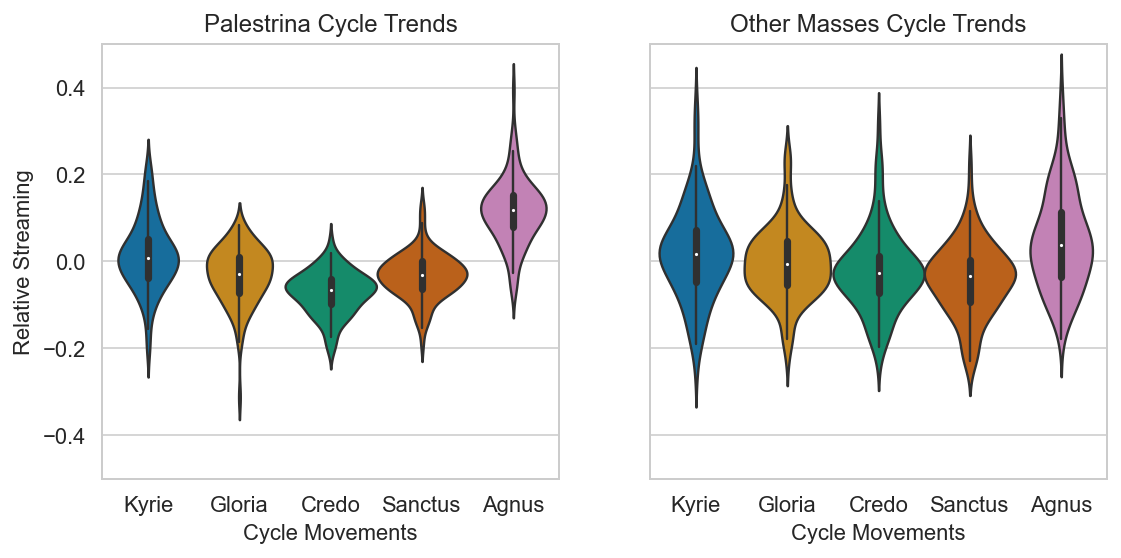

In [51]:
# Palestrina effect? 
# Composers 
# exclude Palistrina because so so many 
sns.set_context("paper")
st = 'C_R_Mean'
Wanted_Comp = 'Giovanni Pierluigi da Palestrina'#,'Tomás Luis de Victoria','Pierre de la Rue','Josquin des Prez','Unverified Josquin','Johannes Ockeghem']
sns.set_style("whitegrid")
Names = Wanted_Comp.split(' ')
Sub_df = cyc_df[cyc_df.Composer==Wanted_Comp]
print(len(Sub_df))
pg.pairwise_gameshowell(data=Sub_df, dv=st,between='Mvnt')  

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))


plt.subplot(1,2,1)
st = 'C_R_Mean'    
ax1 = sns.violinplot(x='Mvnt', y=st,data=Sub_df, width=1,palette="colorblind", order = mainCycle)
ax1.axes.set_xlabel("Relative Mean Streaming",fontsize=11)
ax1.axes.set_ybound(lower=-0.5,upper=0.5)
ax1.set_ylabel("Relative Streaming",fontsize=11)
ax1.set_title("Palestrina Cycle Trends",fontsize=12)
ax1.set_xlabel("Cycle Movements",fontsize=11)
ax1.tick_params(labelsize=11)

Sub_df = cyc_df[cyc_df.Composer!=Wanted_Comp]
pg.pairwise_gameshowell(data=Sub_df, dv=st,between='Mvnt')  

plt.subplot(1,2,2)
ax2 = sns.violinplot(x='Mvnt', y=st,data=Sub_df, 
                 width=1,palette="colorblind", order = mainCycle)
ax2.axes.set_ybound(lower=-0.5,upper=0.5)
ax2.set_xlabel("Cycle Movements",fontsize=11)
ax2.set_ylabel('')
ax2.set_title("Other Masses Cycle Trends",fontsize=12)
ax2.tick_params(labelsize=11)
ax2.set_yticklabels([])

plt.savefig("Palestrina_Movements_SC.png",dpi = 400,bbox_inches = "tight")
plt.show()

494


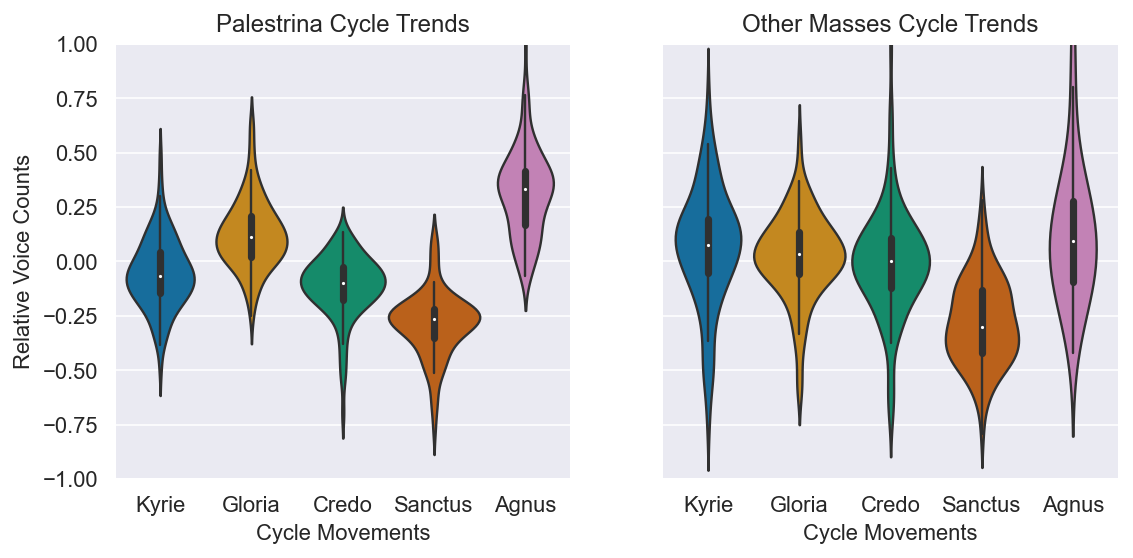

In [52]:
# Palestrina effect? 
# Composers 
# exclude Palistrina because so so many 
sns.set_context("paper")
st = 'V_R_Mean'
Wanted_Comp = 'Giovanni Pierluigi da Palestrina'#,'Tomás Luis de Victoria','Pierre de la Rue','Josquin des Prez','Unverified Josquin','Johannes Ockeghem']
sns.set_style("darkgrid")
Names = Wanted_Comp.split(' ')
Sub_df = cyc_df[cyc_df.Composer==Wanted_Comp]
print(len(Sub_df))
pg.pairwise_gameshowell(data=Sub_df, dv=st,between='Mvnt')  

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))

plt.subplot(1,2,1)
st = 'V_R_Mean'    
ax1 = sns.violinplot(x='Mvnt', y=st,data=Sub_df, width=1,palette="colorblind", order = mainCycle)
ax1.axes.set_ybound(lower=-1,upper=1)
ax1.axes.set_ylabel("Relative Voice Counts",fontsize=11)
ax1.set_title("Palestrina Cycle Trends",fontsize=12)
ax1.set_xlabel("Cycle Movements",fontsize=11)
ax1.tick_params(labelsize=11)

Sub_df = cyc_df[cyc_df.Composer!=Wanted_Comp]
pg.pairwise_gameshowell(data=Sub_df, dv=st,between='Mvnt')  

plt.subplot(1,2,2)
ax2 = sns.violinplot(x='Mvnt', y=st,data=Sub_df, 
                 width=1,palette="colorblind", order = mainCycle)
ax2.axes.set_ybound(lower=-1,upper=1)
ax2.set_xlabel("Cycle Movements",fontsize=11)
ax2.set_ylabel('')
ax2.set_title("Other Masses Cycle Trends",fontsize=12)
ax2.tick_params(labelsize=11)
ax2.set_yticklabels([])

plt.savefig("Palestrina_Movements_VC.png",dpi = 400,bbox_inches = "tight")
plt.show()

494
548
90
952
124
918
60
982
77
965
49
993


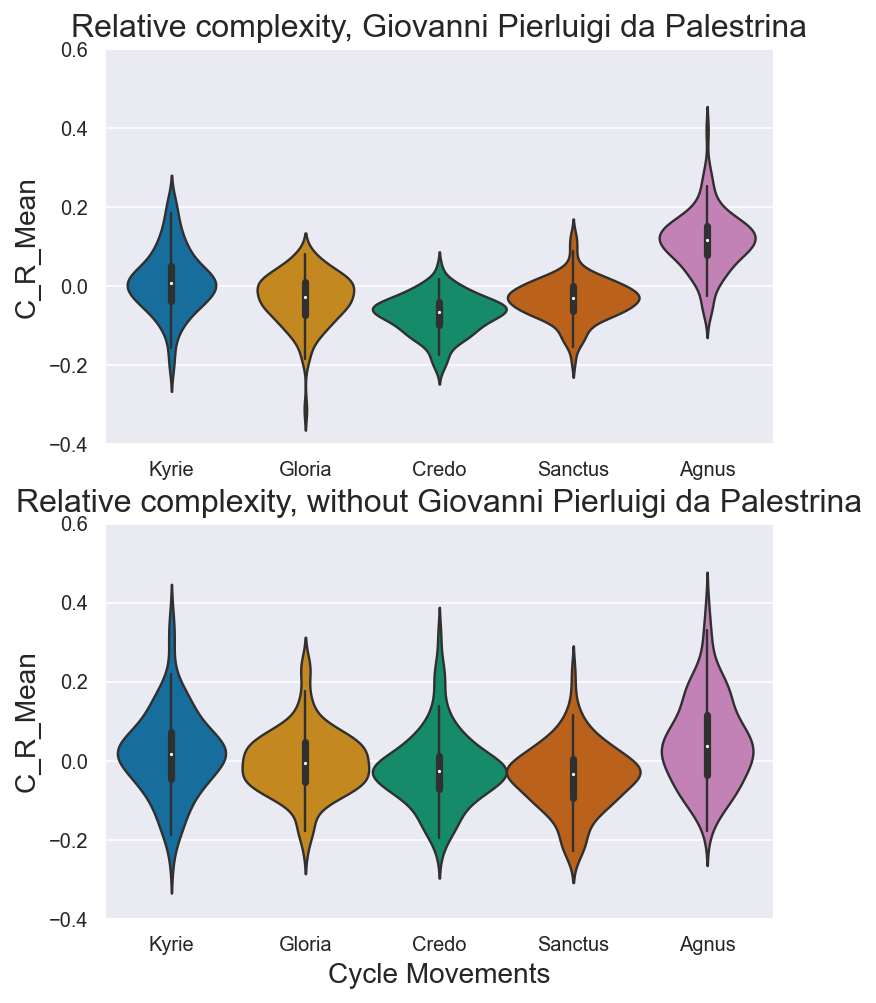

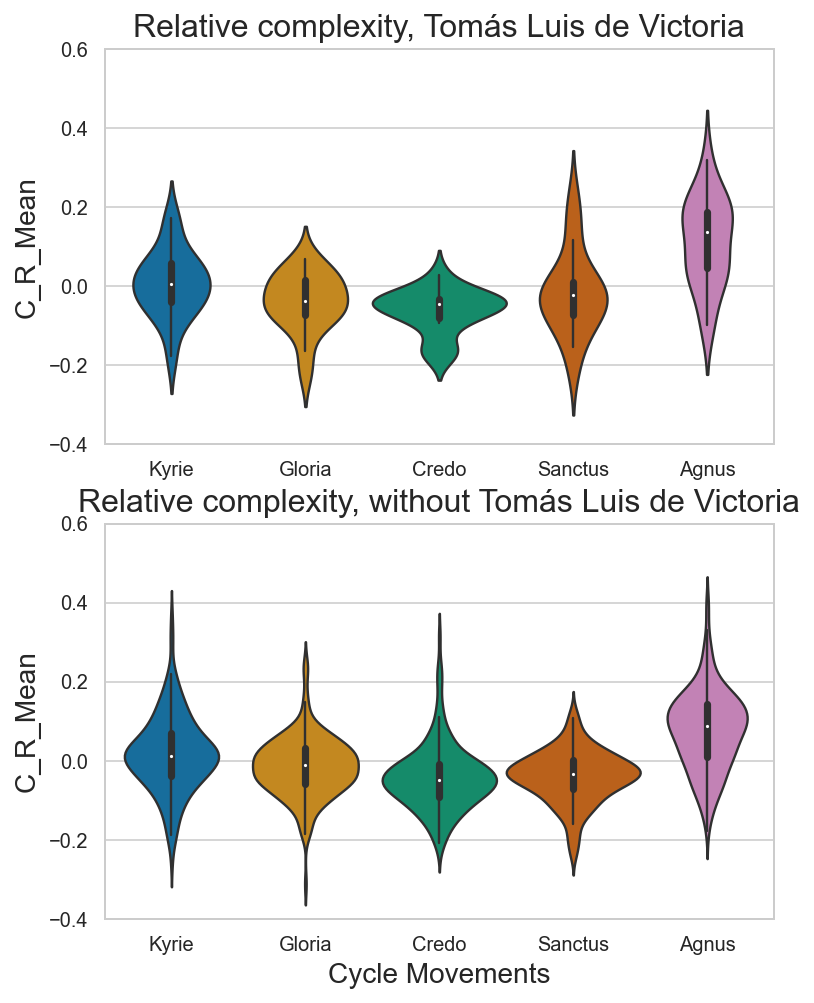

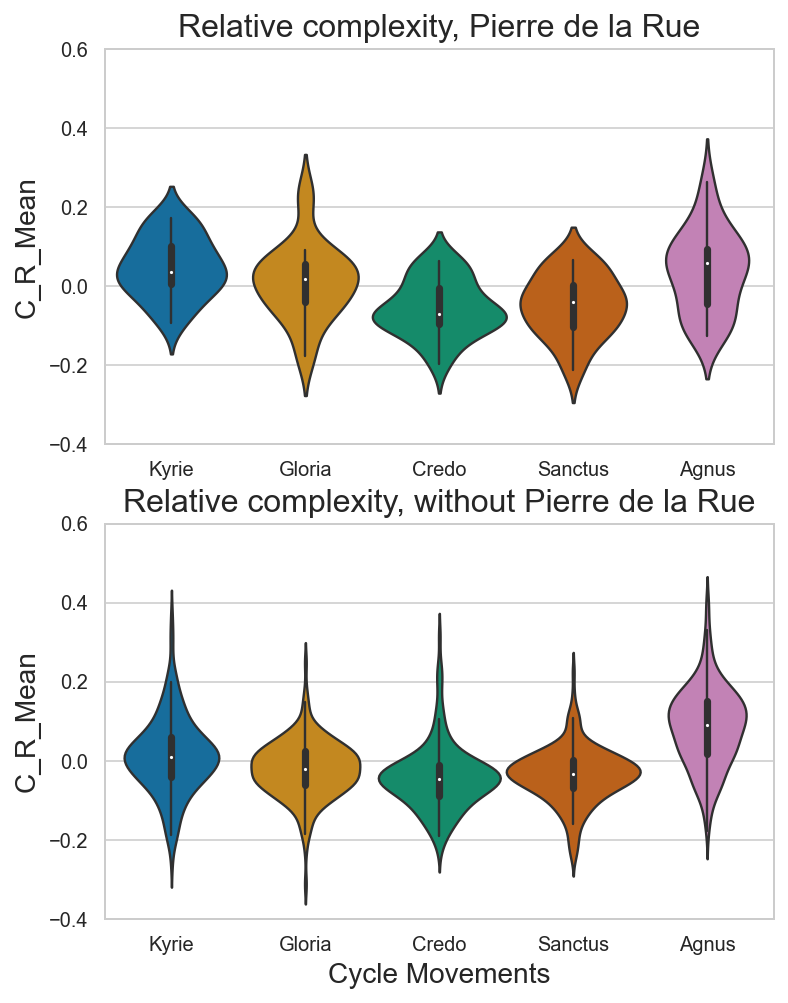

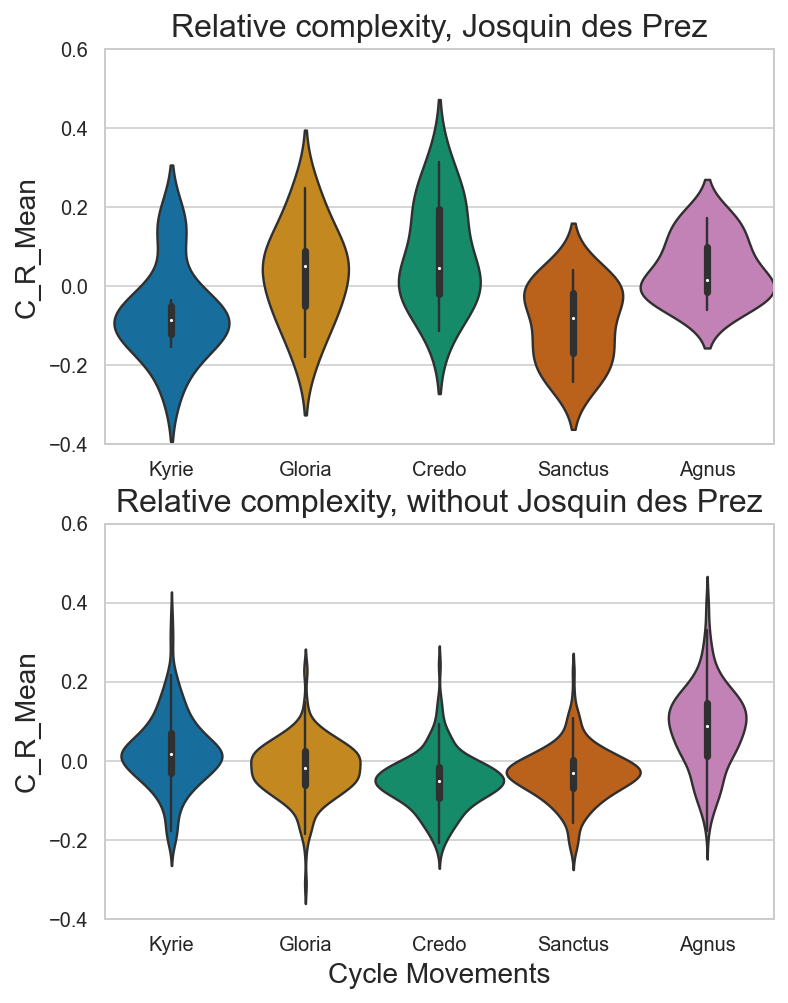

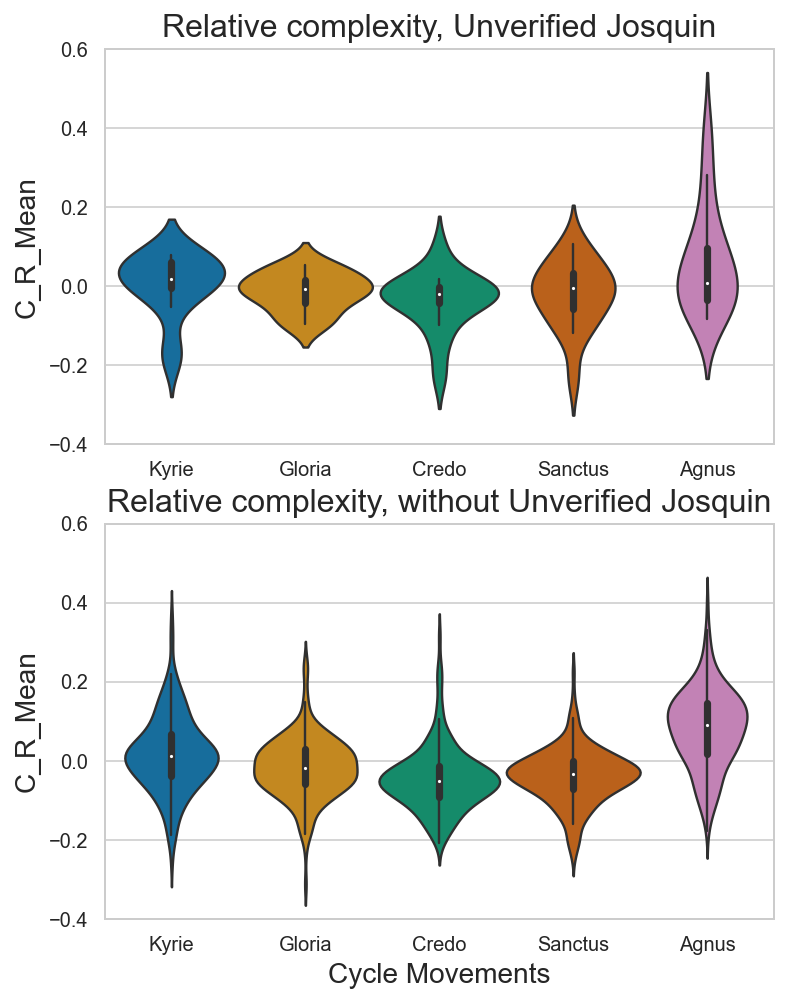

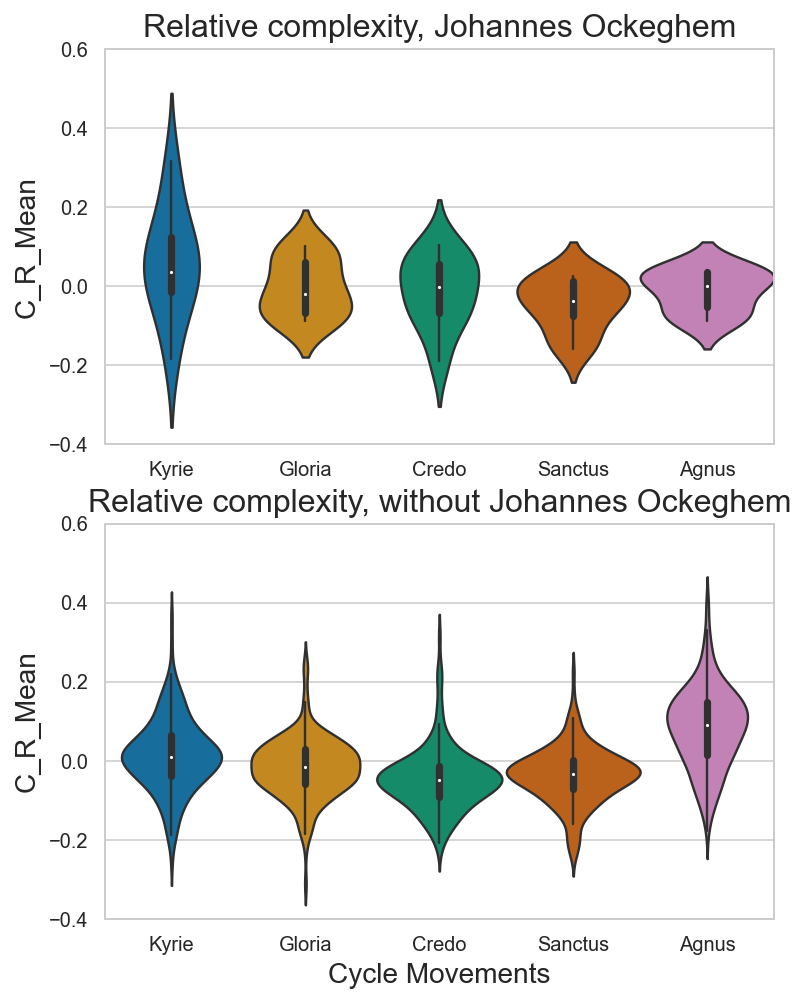

In [53]:
# Palestrina effect? 
# Composers 
# exclude Palistrina because so so many 
sns.set_context("paper")
st = 'C_R_Mean'
Wanted_Composers = ['Giovanni Pierluigi da Palestrina','Tomás Luis de Victoria','Pierre de la Rue','Josquin des Prez','Unverified Josquin','Johannes Ockeghem']
for i in range(len(Wanted_Composers )):
    Names = Wanted_Composers[i].split(' ')
    Wanted_Comp = [Wanted_Composers[i]]
    Sub_df = cyc_df[cyc_df.Composer.isin(Wanted_Comp)]
    print(len(Sub_df))

    Sub_df = Sub_df.reset_index(drop = True)

    f, axes = plt.subplots(2,1, sharey=True, figsize=(6, 8))
    bplot = sns.violinplot(x='Mvnt', y=st,data=Sub_df, 
                     width=1,palette="colorblind", order = mainCycle,ax = axes[0])
#     bplot=sns.stripplot(x='Mvnt', y=st,data=Sub_df, 
#                        jitter=True, marker='o',alpha=0.75,
#                        color='black', order = mainCycle,ax = axes[0])

    bplot.axes.set_title("Relative complexity, " +  Wanted_Composers[i],fontsize=16)
    bplot.axes.set_ybound(lower=-0.4,upper=0.6)
    bplot.set_xlabel(" ",fontsize=14)
    bplot.set_ylabel(st ,fontsize=14)
    bplot.tick_params(labelsize=10)
    bplot=sns.set_style("whitegrid")

    Sub_df = cyc_df[~cyc_df.Composer.isin(Wanted_Comp)]
    print(len(Sub_df))

    Sub_df = Sub_df.reset_index(drop = True)

    bplot = sns.violinplot(x='Mvnt', y=st,data=Sub_df, 
                     width=1,palette="colorblind", order = mainCycle,ax = axes[1])
#     bplot=sns.stripplot(x='Mvnt', y=st,data=Sub_df, 
#                        jitter=True, marker='o',alpha=0.75,
#                        color='black', order = mainCycle,ax = axes[1])

    bplot.axes.set_title("Relative complexity, without " +  Wanted_Composers[i],fontsize=16)
    bplot.axes.set_ybound(lower=-0.4,upper=0.6)
    bplot.set_xlabel("Cycle Movements",fontsize=14)
    bplot.set_ylabel(st ,fontsize=14)
    bplot.tick_params(labelsize=10)
    bplot=sns.set_style("whitegrid")
                     
   # plt.savefig(st + "_wo_" + Names[-1] + ".png",dpi = 200,bbox_inches = "tight")

# Individual masses

In [54]:
# retreive the last round of evaluations

os.chdir('/Users/finn/Documents/DDMAL/Scores')
f=open('Masses_CompSeries_Stream3_3.pkl','rb')
S_Complexities=pickle.load(f)
f.close()

MusicIndex = S_Complexities['MusicIndex']
Counterpoint_seperated = S_Complexities['Streaming_Complexity']
Voices_counted = S_Complexities['Voice_Counts']

os.chdir('/Users/finn/Documents/DDMAL/Scores/masses_all')
print(len(MusicIndex))
print(len(Counterpoint_seperated))
print(len(Voices_counted))

1051
1051
1051


In [55]:
os.chdir('/Users/finn/Documents/DDMAL/dev/complexity/masses')

In [56]:
# fd carries over values from previous analysis, including metadata on each movement.
df=pd.DataFrame(columns=['Mass','MassID','Mvnt','Composer','CompID','C_Mean','C_Max','file']) #,'V_Median','V_Max'])

# choose form of complexity summary series to evaluate
Comp_Type = 'Counterpoint Complexity'
SC=Counterpoint_seperated

# fd carries over values from previous analysis, including metadata on each movement.
central_Stat = []
max_Stat = []
for i in range(len(SC)):
    df_seperated = SC[i]
    central_Stat=np.nanmean(df_seperated)
    max_Stat=np.nanmax(df_seperated)
    df = df.append({'Mass':MusicIndex.Mass[i],'MassID':MusicIndex.MassID[i],
                    'Mvnt':MusicIndex.Mvnt[i],'Composer':MusicIndex.Composer[i],
                    'CompID':MusicIndex.CompID[i], 'C_Mean':central_Stat,'C_Max':max_Stat,'file':MusicIndex.file},ignore_index=True)


# choose form of complexity summary series to evaluate

Comp_Type = 'Voice Counts'
VC=Voices_counted

# fd carries over values from previous analysis, including metadata on each movement.
central_Stat = []
max_Stat = []

for i in range(len(VC)):
    df_seperated = VC[i]
    central_Stat.append(np.nanmean(df_seperated))
    max_Stat.append(np.nanmax(df_seperated))
len(central_Stat)
# add to df
df.insert(7, "V_Mean", central_Stat, True)
df.insert(8, "V_Max", max_Stat, True)


In [57]:
# reduce collection to relevant factors
# https://cmdlinetips.com/2018/02/how-to-subset-pandas-dataframe-based-on-values-of-a-column/

# Restrict Cycle movements 
print(len(df))
mainCycle = ['Kyrie','Gloria', 'Credo', 'Sanctus', 'Agnus']
cyc_df = df[df.Mvnt.isin(mainCycle)]
print(len(cyc_df))

# drop those few with insufficient voices to be worth calculating around
cyc_df = cyc_df[cyc_df.V_Max>2] 
print(len(cyc_df))


cyc_df['Composer'].value_counts()

1051
1051
1042


Giovanni Pierluigi da Palestrina    494
Pierre de la Rue                    124
Tomás Luis de Victoria               90
Unverified Josquin                   77
Josquin des Prez                     60
Johannes Ockeghem                    49
Johannes Martini                     38
Marbrianus de Orto                   25
Guillaume Du Fay                     20
Anonymus                             15
Obrecht                              11
Johannes Tinctoris                   10
Alexander Agricola                    9
Antoine de Fevin                      5
Antoine Busnoys                       5
Pipelare                              5
Ludwig Daser                          5
Name: Composer, dtype: int64

In [59]:
mi = 'Pal1048'
ma = "Missa Iste confessor"
Sub_df = cyc_df[cyc_df.MassID==mi]
sI = list(Sub_df.index)
sI

[695, 696, 697, 698, 699]

Agnus
[0, 0, 0, 0, 4.338685636856368]
Credo
[0, 0, 3.5213951067152527, 0, 4.338685636856368]
Gloria
[0, 3.603145235892692, 3.5213951067152527, 0, 4.338685636856368]
Kyrie
[3.4616110304789554, 3.603145235892692, 3.5213951067152527, 0, 4.338685636856368]
Sanctus
[3.4616110304789554, 3.603145235892692, 3.5213951067152527, 3.2114533965244862, 4.338685636856368]


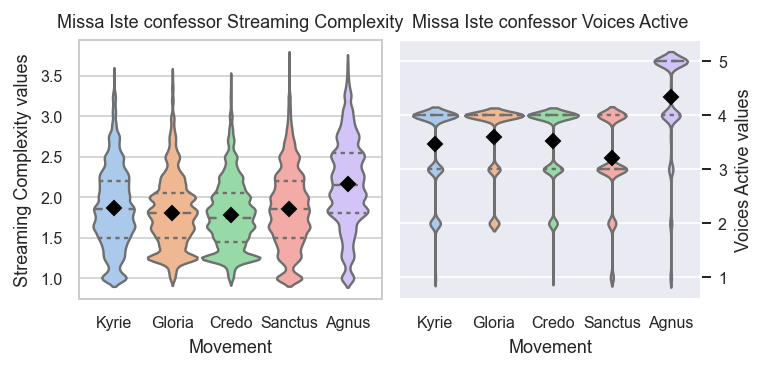

In [60]:
# mi = 'Pal1024'
# ma = "Missa " + "Iste confessor"
Sub_df = cyc_df[cyc_df.MassID==mi]
sI = list(Sub_df.index)
df_A = pd.DataFrame(dict(x = [],g = []))
df_C = pd.DataFrame(dict(x = [],g = []))
mmm = ['Kyrie','Gloria','Credo','Sanctus','Agnus']
n_move = {'Kyrie':0,'Gloria':1,'Credo':2,'Sanctus':3,'Agnus':4}

m_A = [0,0,0,0,0]
m_C = [0,0,0,0,0]
for i in sI:
    mv = Sub_df.loc[i,'Mvnt']
    print(mv)
    mv_n = n_move[mv]
    df = pd.DataFrame(dict(x=Voices_counted[i], g=mv_n))
    m_A[mv_n] = df.x.mean()
    print(m_A)
    df_A = df_A.append(df, ignore_index=True)
    df = pd.DataFrame(dict(x=Counterpoint_seperated[i], g=mv_n))
    df_C = df_C.append(df, ignore_index=True)
    m_C[mv_n] = df.x.mean()
df_A = df_A.sort_values(by='g')
df_C = df_C.sort_values(by='g')


left, width = 0.14, 0.35
bottom, height = 0.18, 0.72
spacing = 0.02

# start with a square Figure
fig= plt.figure(figsize=(6,2.5))
sns.set_context("paper")
sns.set_style("whitegrid")
n = 1
rect = [left + (n-1)*(width + spacing), bottom, width, height]
ax1 = fig.add_axes(rect)

sns.violinplot(x='g', y='x',data=df_C, width=1,palette="pastel",bw=.1,inner='quartile')
for i in range(len(m_C)):
    ax1.plot([i],m_C[i],color ='black', marker="D", markersize=5)
ax1.set_xticks([0,1,2,3,4])
ax1.set_xticklabels(mmm)
ax1.axes.set_xlabel("Relative Mean Streaming",fontsize=9)
ax1.set_ylabel("Streaming Complexity values",fontsize=9)
ax1.set_title(ma + " Streaming Complexity",fontsize=9)
ax1.set_xlabel("Movement",fontsize=9)
ax1.tick_params(labelsize=8)


sns.set_style("darkgrid")
n += 1
rect = [left + (n-1)*(width + spacing), bottom, width, height]
ax2 = fig.add_axes(rect)

st = 'V_R_Mean'
i=1
sns.violinplot(x='g', y='x',data=df_A, width=1,palette="pastel",bw=.1,inner='quartile')
for i in range(len(m_C)):
    ax2.plot([i],m_A[i],color ='black', marker="D", markersize=5)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.set_xlabel("Movement",fontsize=9)

ax2.set_ylabel("Voices Active values",fontsize=9)
ax2.set_title(ma + " Voices Active",fontsize=9)
ax2.tick_params(labelsize=8)
ax2.set_xticks([0,1,2,3,4])
ax2.set_xticklabels(mmm)

plt.savefig(mi +"_mvmt_dist.png",dpi = 400)



Kyrie
[2.977661431064572, 0, 0, 0, 0]
Gloria
[2.977661431064572, 3.392588841056809, 0, 0, 0]
Credo
[2.977661431064572, 3.392588841056809, 3.6810834425513352, 0, 0]
Sanctus
[2.977661431064572, 3.392588841056809, 3.6810834425513352, 2.933619679812573, 0]
Agnus
[2.977661431064572, 3.392588841056809, 3.6810834425513352, 2.933619679812573, 3.2753353973168213]


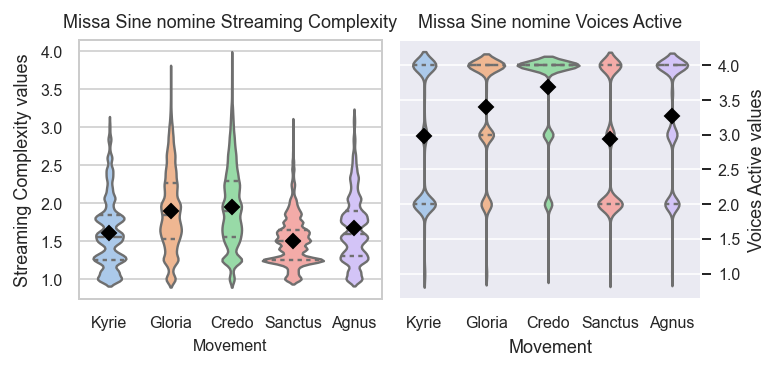

In [61]:
mi = 'Jos1202'
ma = "Missa Sine nomine"
Sub_df = cyc_df[cyc_df.MassID==mi]
sI = list(Sub_df.index)
df_A = pd.DataFrame(dict(x = [],g = []))
df_C = pd.DataFrame(dict(x = [],g = []))
mmm = ['Kyrie','Gloria','Credo','Sanctus','Agnus']
n_move = {'Kyrie':0,'Gloria':1,'Credo':2,'Sanctus':3,'Agnus':4}

m_A = [0,0,0,0,0]
m_C = [0,0,0,0,0]
for i in sI:
    mv = Sub_df.loc[i,'Mvnt']
    print(mv)
    mv_n = n_move[mv]
    df = pd.DataFrame(dict(x=Voices_counted[i], g=mv_n))
    m_A[mv_n] = df.x.mean()
    print(m_A)
    df_A = df_A.append(df, ignore_index=True)
    df = pd.DataFrame(dict(x=Counterpoint_seperated[i], g=mv_n))
    df_C = df_C.append(df, ignore_index=True)
    m_C[mv_n] = df.x.mean()
df_A = df_A.sort_values(by='g')
df_C = df_C.sort_values(by='g')


left, width = 0.14, 0.35
bottom, height = 0.18, 0.72
spacing = 0.02

# start with a square Figure
fig= plt.figure(figsize=(6,2.5))
sns.set_context("paper")
sns.set_style("whitegrid")
n = 1
rect = [left + (n-1)*(width + spacing), bottom, width, height]
ax1 = fig.add_axes(rect)

sns.violinplot(x='g', y='x',data=df_C, width=1,palette="pastel",bw=.1,inner='quartile')
for i in range(len(m_C)):
    ax1.plot([i],m_C[i],color ='black', marker="D", markersize=5)
ax1.set_xticks([0,1,2,3,4])
ax1.set_xticklabels(mmm)
ax1.axes.set_xlabel("Relative Mean Streaming",fontsize=9)
ax1.set_ylabel("Streaming Complexity values",fontsize=9)
ax1.set_title(ma + " Streaming Complexity",fontsize=9)
ax1.set_xlabel("Movement",fontsize=8)
ax1.tick_params(labelsize=8)

sns.set_style("darkgrid")
n += 1
rect = [left + (n-1)*(width + spacing), bottom, width, height]
ax2 = fig.add_axes(rect)


st = 'V_R_Mean'
i=1
ax2 = sns.violinplot(x='g', y='x',data=df_A, width=1,palette="pastel",bw=.1,inner='quartile')
for i in range(len(m_C)):
    ax2.plot([i],m_A[i],color ='black', marker="D", markersize=5)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.set_xlabel("Movement",fontsize=9)

ax2.set_ylabel("Voices Active values",fontsize=9)
ax2.set_title(ma + " Voices Active",fontsize=9)
ax2.tick_params(labelsize=8)
ax2.set_xticks([0,1,2,3,4])
ax2.set_xticklabels(mmm)

plt.savefig(mi +"_mvmt_dist.png",dpi = 400)

